# DivPs analysis Chain AF OVA data 50000 random subsmpl

TCRDivER analysis of the Murine dataset with Athchley factor distance used as TCR distance metric. 


**Instructions** 

Set path to working directory which should contain: 

* divP_tsv directory: containting all the diversities calculated at varying $q$ and $\lambda$s the TCRDivER algorithm outputs
* filtered directory: containing all the filetered TCR repertoires the TCRDivER algorithm outputs


In [80]:
from os import listdir
from os.path import isfile, join
import os
import re
import pandas as pd
from collections import defaultdict
from collections import OrderedDict
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import decomposition
from sklearn.metrics import accuracy_score

In [81]:
def plt_divP(divP_df, sample_name, time, treatment, wdir_path): 
    divP_df_long = pd.melt(divP_df, "q", var_name = "Lambda", value_name = "DqZ")
    qs_label = [q if q != "7" else "$\infty$" for q in list(map(str, divP_df["q"]))]
    sns.color_palette("colorblind")
    plt.figure(figsize=(6,8))
    ax =sns.lineplot(x="q", y="DqZ", data=divP_df_long, hue = "Lambda", markers=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.fill_between(divP_df["q"].values, divP_df["16.0"].values, divP_df["identity"].values, 
                 facecolor='red', alpha = 0.2)
    
    plt.xticks(ticks = divP_df["q"].values, labels = qs_label, fontsize = 13)
    plt.yticks(ticks = range(0,13), fontsize = 13)
    plt.ylim(top=12)
    plt.xlabel("q", fontsize = 20)
    plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
    plt.title(sample_name, fontsize = 20)
    if not os.path.isdir(wdir_path+"divPs/"):
        os.makedirs(wdir_path+"divPs/", exist_ok=False)
    plt.savefig(wdir_path + "divPs/"+ sample_name + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
    return plt

In [82]:
def calculate_area_between_curves(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas.reverse()
    area_dict = OrderedDict()
    for index,first in list(enumerate(lambdas)):
        for second in lambdas[index+1:]:
            area = np.trapz(divP_df[first].values , x=divP_df["q"].values) - np.trapz(divP_df[second].values , x=divP_df["q"].values)
            area_dict["_".join([first, second, "area"])] = area
    return area_dict



In [83]:
def calculate_slopes(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas = [lb for lb in lambdas if lb != "0.0"]
    lambdas.reverse()
    slope_dict = OrderedDict()
    for lb in lambdas: 
        slope_dict["_".join(["0_1_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[1, lb]
        slope_dict["_".join(["0_2_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[2, lb]
        slope_dict["_".join(["1_2_slope", lb])] = divP_df.loc[1, lb]-divP_df.loc[2, lb]
    return slope_dict

In [84]:
def calculate_avg_delta_lambda_05_00(divP_df):
    avg_delta_lambda = divP_df[["0.0","0.1","0.2", "0.3", "0.4", "0.5"]].diff(axis = 1).mean().mean()
    return avg_delta_lambda

In [85]:
def make_divP_one_row_df(divP_df):
    divP_df_wo_L0 = divP_df.drop("0.0", axis = 1)
    list_of_lambdas = [lmbd for lmbd in list(divP_df_wo_L0) if lmbd != "q"]
    list_of_dqz = list()
    for lmbd in list_of_lambdas:
        for qu in divP_df_wo_L0["q"]:
            if qu == 7: 
                qu = 11
                qu_name = "infinity"
            qu_name = str(qu)
            list_of_dqz.append(("L_"+ lmbd + "_q_" +qu_name, divP_df_wo_L0.loc[qu,lmbd]))
    sample_dqz = pd.DataFrame(list_of_dqz).T
    sample_dqz.columns = sample_dqz.iloc[0]
    sample_dqz = sample_dqz.drop(sample_dqz.index[0])
    sample_dqz = sample_dqz.reset_index(drop = "True")
    return sample_dqz



In [86]:
# Set path to working directory:
wdir_path = "/Users/milvu/Documents/OneDrive - Danmarks Tekniske Universitet/TCR_analysis/TCRDivER_algorithm/datasets_divP_calculated/Chain_OVAexprt_data_AF_50000_random_subsmpl/"

#set path to metadata excel file
path_to_metadata ="metadata/Cinelli_et_al_NF_MouseData_OVA_data_1.csv"


Let's make the metadata dataframe from the filenames themselves by establishing some criteria. 

# OVA data 1

In [87]:
# Read in metadata: 
mddf = pd.read_csv(wdir_path+ path_to_metadata, sep = ",")
mddf = mddf[["OVA data 1", "library", "in-vivo treatment", "post-immunisation time", "sample type"]]
mddf.columns = ["sample_name", "library", "treatment", "post_imm_time", "sample_type"]
mddf.loc[(mddf.post_imm_time == 'm2'),'post_imm_time']='d60'
mddf.sort_values(by=["post_imm_time", "treatment"], inplace=True)
mddf = mddf.reset_index(drop = True)

In [88]:
#read in filtered filenames and count unique CDR3s
filtered_fpath = wdir_path + "filtered/"
files = [f for f in listdir(filtered_fpath) if isfile(join(filtered_fpath, f))]
files = [f for f in listdir(filtered_fpath) if f.endswith(".tsv")]
unique_CDR3s_dict = defaultdict()
column_names = ["sample_name", "age", "immunisation", "unique_CDR3s"]
for file in files: 
    num_lines = sum(1 for line in open(filtered_fpath+file))
    unique_CDR3s_dict["_".join(file.split("_")[:-1])]=num_lines

files

['SB2_GTC_clean_cdr3_filtered.tsv',
 'SB2_CCG_clean_cdr3_filtered.tsv',
 'SB2_ATT_clean_cdr3_filtered.tsv',
 'SB1_CAC_clean_cdr3_filtered.tsv',
 'SB2_ACC_clean_cdr3_filtered.tsv',
 'SB1_TAT_clean_cdr3_filtered.tsv',
 'EAE1B_CCG_clean_cdr3_filtered.tsv',
 'EAE1B_TTG_clean_cdr3_filtered.tsv',
 'SB1_TGC_clean_cdr3_filtered.tsv',
 'SB2_GCT_clean_cdr3_filtered.tsv',
 'SB1_GCT_clean_cdr3_filtered.tsv',
 'SB1_GAG_clean_cdr3_filtered.tsv',
 'EAE1A_TTG_clean_cdr3_filtered.tsv',
 'SB1_AGG_clean_cdr3_filtered.tsv',
 'SB1_CTA_clean_cdr3_filtered.tsv',
 'SB1_AAA_clean_cdr3_filtered.tsv',
 'SB1_TCA_clean_cdr3_filtered.tsv',
 'CPX1A_GGA_clean_cdr3_filtered.tsv',
 'SB1_ACC_clean_cdr3_filtered.tsv',
 'CPX1A_TTG_clean_cdr3_filtered.tsv',
 'CPX1B_CAC_clean_cdr3_filtered.tsv',
 'SB1_ATT_clean_cdr3_filtered.tsv',
 'SB1_CCG_clean_cdr3_filtered.tsv',
 'SB2_CAC_clean_cdr3_filtered.tsv',
 'SB1_TTG_clean_cdr3_filtered.tsv',
 'SB1_GTC_clean_cdr3_filtered.tsv',
 'SB2_CGT_clean_cdr3_filtered.tsv',
 'EAE1A_GGA_clea

In [89]:
unique_CDR3_list = [unique_CDR3s_dict["".join([row["sample_name"], "_clean_cdr3"])] for index, row in mddf.iterrows()]
mddf["unique_CDR3s"] = unique_CDR3_list
mddf

sample_name library  treatment post_imm_time sample_type  unique_CDR3s
0    CPX1A_GGA     CPX  untreated            d0      spleen         32295
1    CPX1A_TTG     CPX  untreated            d0      spleen         30541
2    CPX1B_CAC     CPX  untreated            d0      spleen         30131
3    EAE1A_GGA     EAE  untreated            d0      spleen         28170
4    EAE1A_TTG     EAE  untreated            d0      spleen         28699
5    EAE1B_CCG     EAE  untreated            d0      spleen         14866
6    EAE1B_TTG     EAE  untreated            d0      spleen         21506
7      SB1_TGC     SB1  untreated            d0      spleen         21727
8      SB1_ACC     SB1        CFA           d14      spleen         27156
9      SB1_CTA     SB1        CFA           d14      spleen         25445
10     SB1_GCT     SB1        CFA           d14      spleen         25435
11     SB1_AGG     SB1        OVA           d14      spleen         33190
12     SB1_GAG     SB1        OVA           d14      spleen         27132
13     SB1_TAT     SB1        OVA           d14      spleen         32121
14     SB1_AAA     SB1        CFA            d5      spleen         30400
15     SB1_CCG     SB1        CFA            d5      spleen         29493
16     SB1_TTG     SB1        CFA            d5      spleen         32263
17     SB1_ATT     SB1        OVA            d5      spleen         31315
18     SB1_CAC     SB1        OVA            d5      spleen         30520
19     SB1_GTC     SB1        OVA            d5      spleen         32077
20     SB2_ATT     SB2        CFA           d60      spleen         19626
21     SB2_CCG     SB2        CFA           d60      spleen         23146
22     SB2_CGT     SB2        CFA           d60      spleen         15539
23     SB2_CAC     SB2        OVA           d60      spleen         16251
24     SB2_GCT     SB2        OVA           d60      spleen         20608
25     SB2_GTC     SB2        OVA           d60      spleen         17966

## Plot Diversity Profiles for individual samples 

In [90]:
# load filenames: 
divP_fpath = wdir_path + "divP_tsv/"
divP_files = [f for f in listdir(divP_fpath) if isfile(join(divP_fpath, f))]
divP_files = [f for f in divP_files if f.endswith('tsv')]
divP_files = [re.sub('\.tsv$', '', f) for f in divP_files]
divP_files.sort()
divP_files = [f for f in divP_files]

divP_files

['CPX1A_GGA_clean_cdr3_divP',
 'CPX1A_TTG_clean_cdr3_divP',
 'CPX1B_CAC_clean_cdr3_divP',
 'EAE1A_GGA_clean_cdr3_divP',
 'EAE1A_TTG_clean_cdr3_divP',
 'EAE1B_CCG_clean_cdr3_divP',
 'EAE1B_TTG_clean_cdr3_divP',
 'SB1_AAA_clean_cdr3_divP',
 'SB1_ACC_clean_cdr3_divP',
 'SB1_AGG_clean_cdr3_divP',
 'SB1_ATT_clean_cdr3_divP',
 'SB1_CAC_clean_cdr3_divP',
 'SB1_CCG_clean_cdr3_divP',
 'SB1_CTA_clean_cdr3_divP',
 'SB1_GAG_clean_cdr3_divP',
 'SB1_GCT_clean_cdr3_divP',
 'SB1_GTC_clean_cdr3_divP',
 'SB1_TAT_clean_cdr3_divP',
 'SB1_TGC_clean_cdr3_divP',
 'SB1_TTG_clean_cdr3_divP',
 'SB2_ATT_clean_cdr3_divP',
 'SB2_CAC_clean_cdr3_divP',
 'SB2_CCG_clean_cdr3_divP',
 'SB2_CGT_clean_cdr3_divP',
 'SB2_GCT_clean_cdr3_divP',
 'SB2_GTC_clean_cdr3_divP']

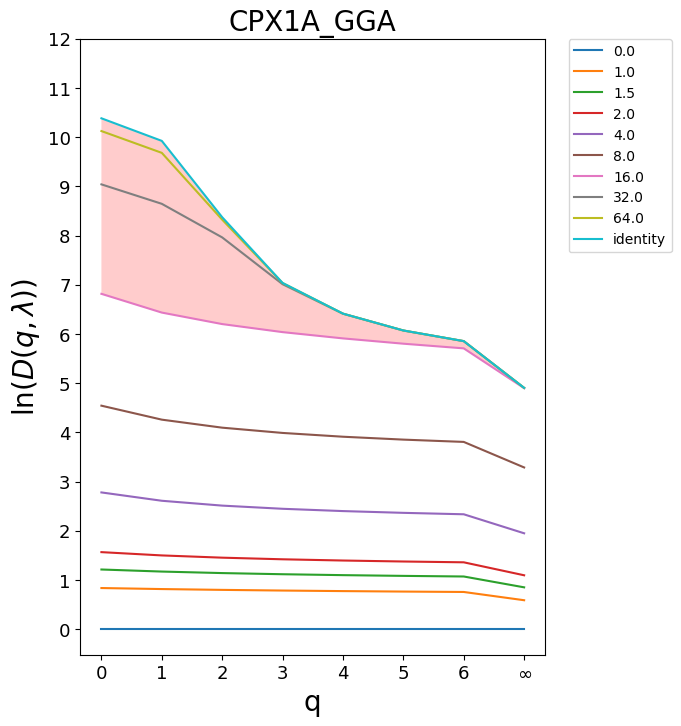

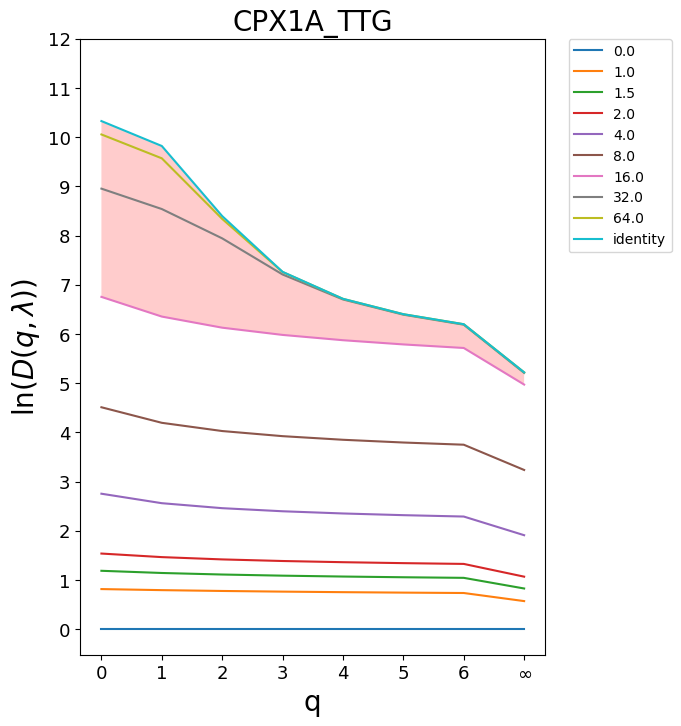

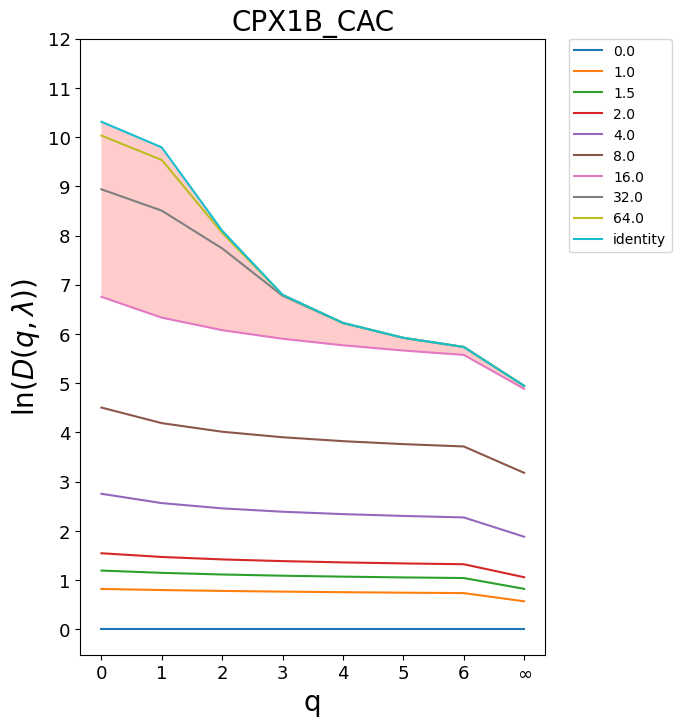

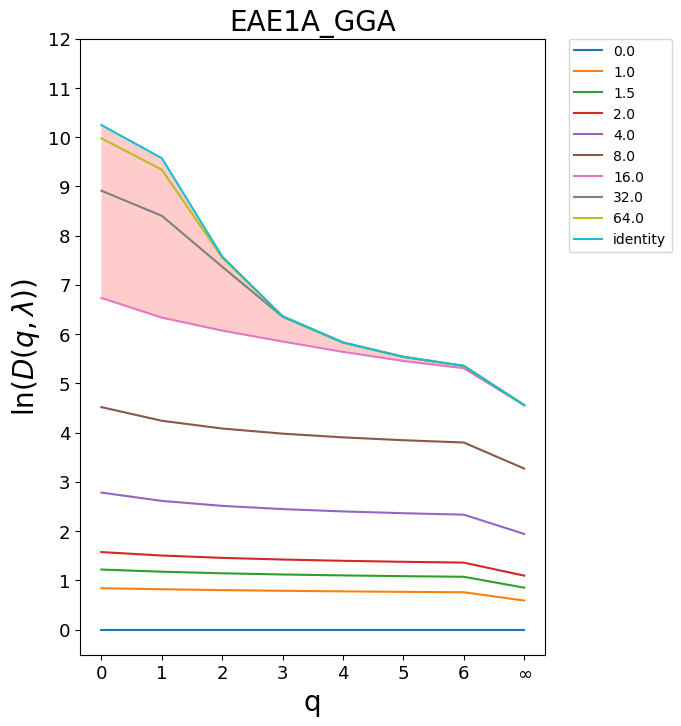

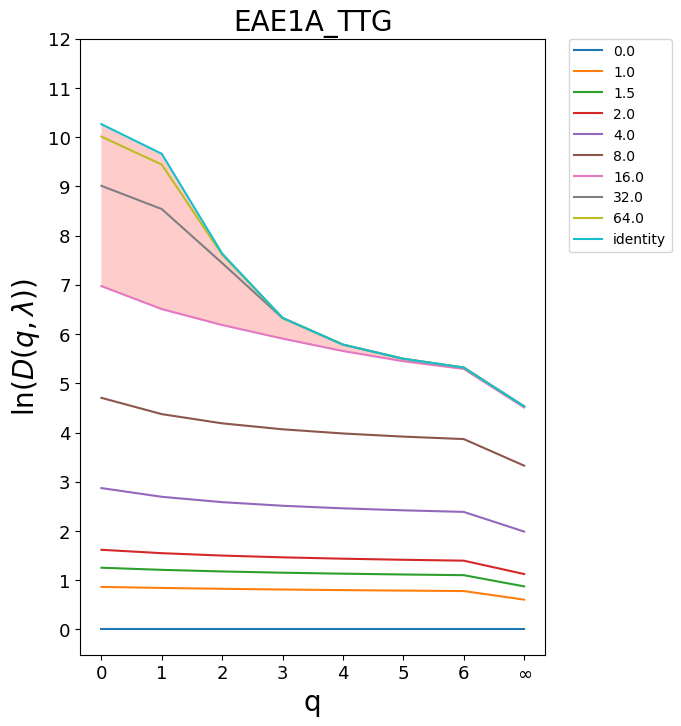

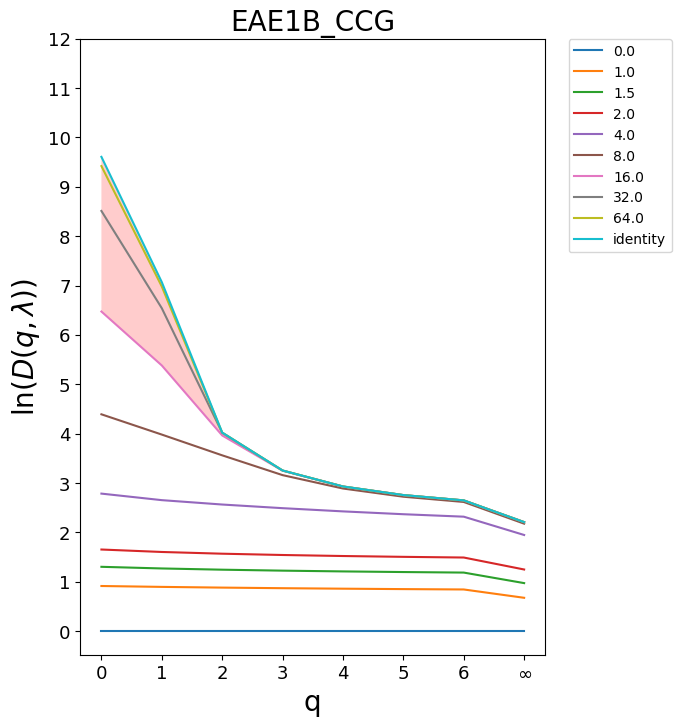

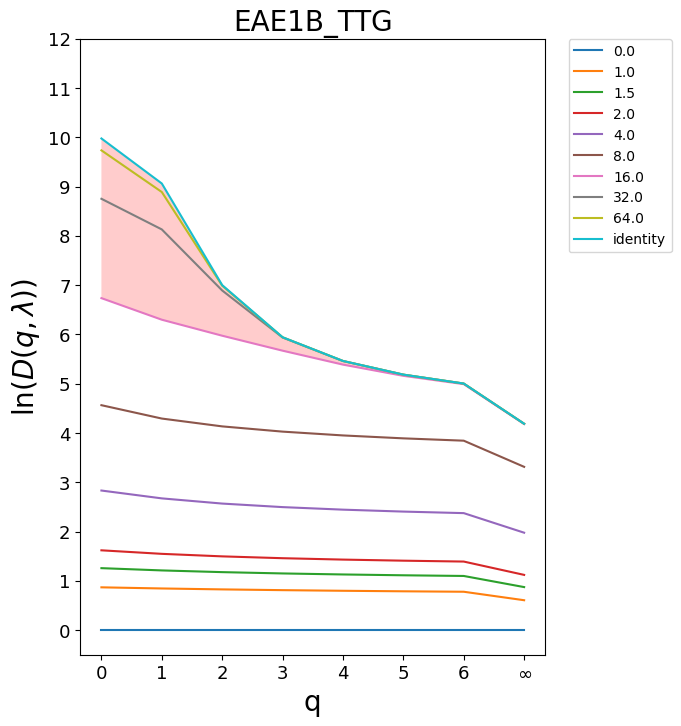

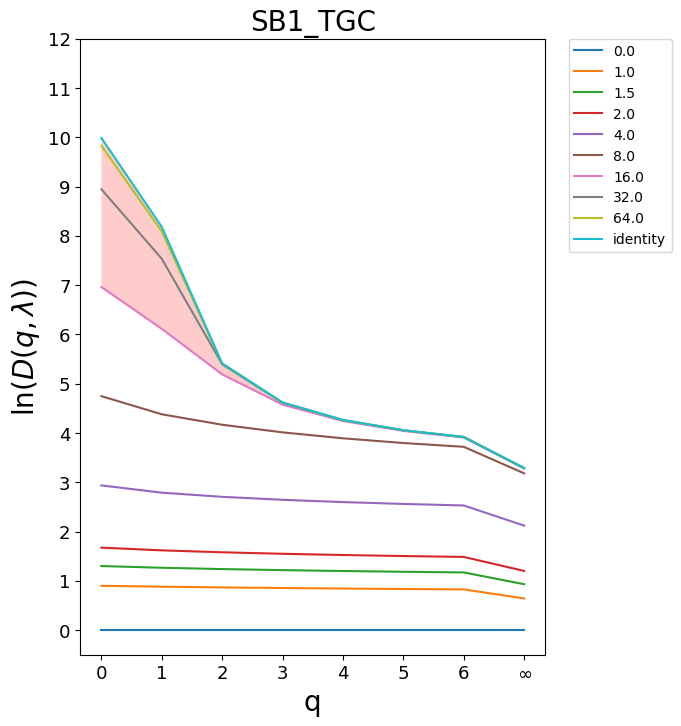

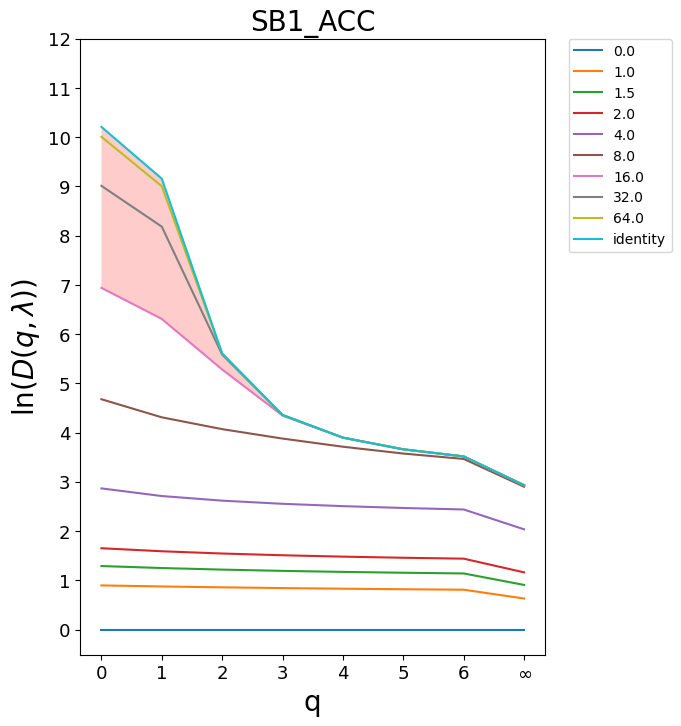

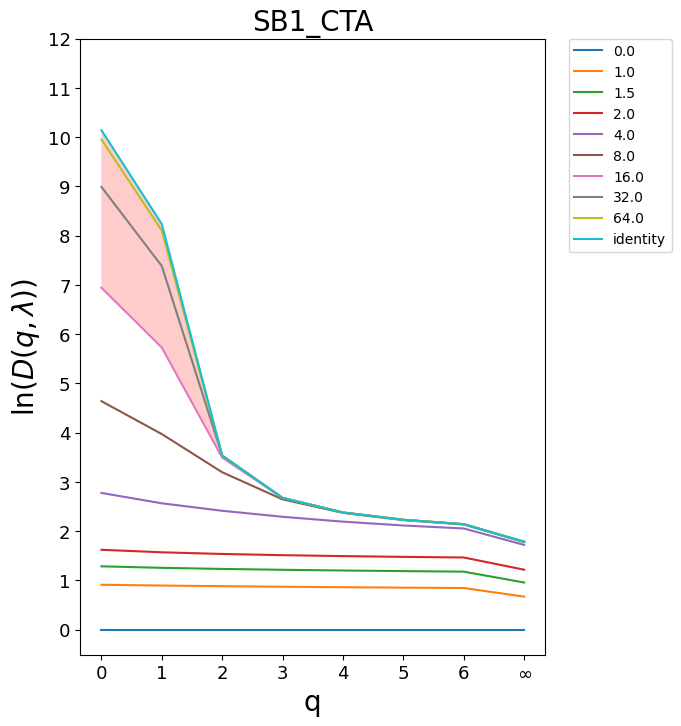

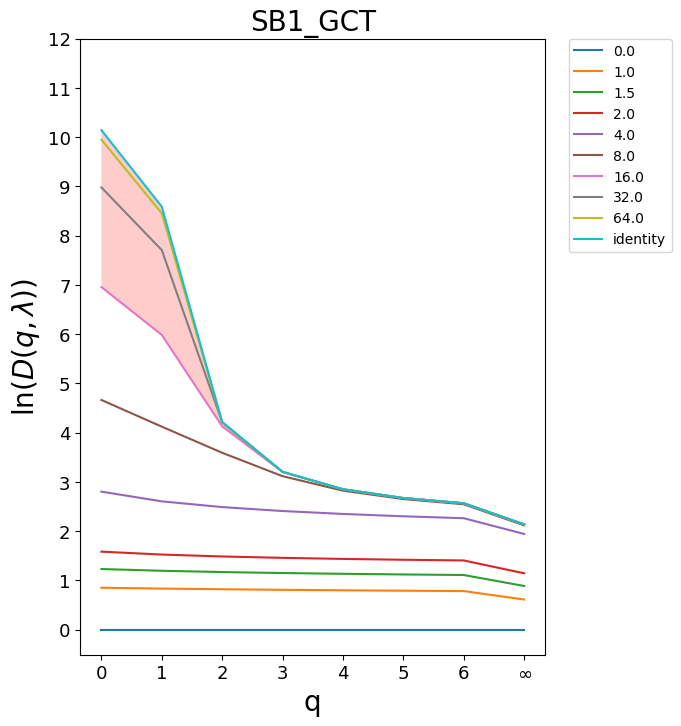

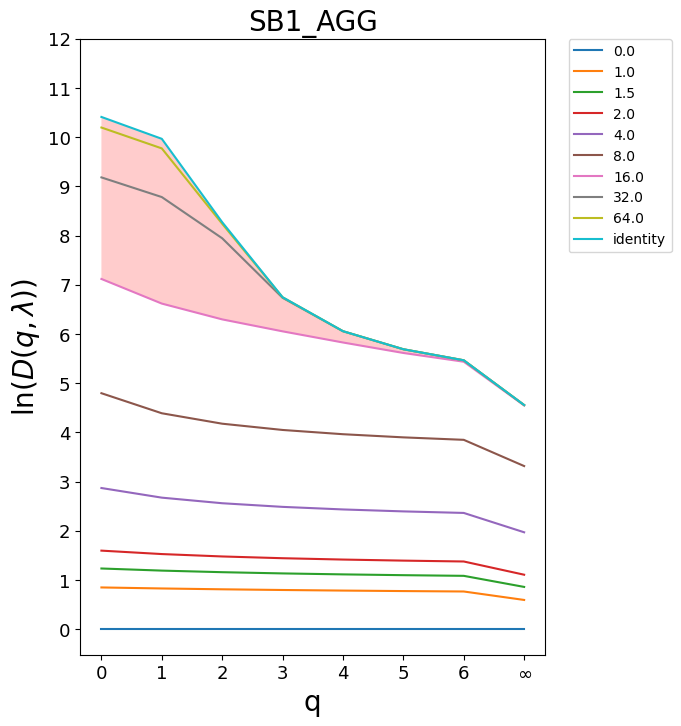

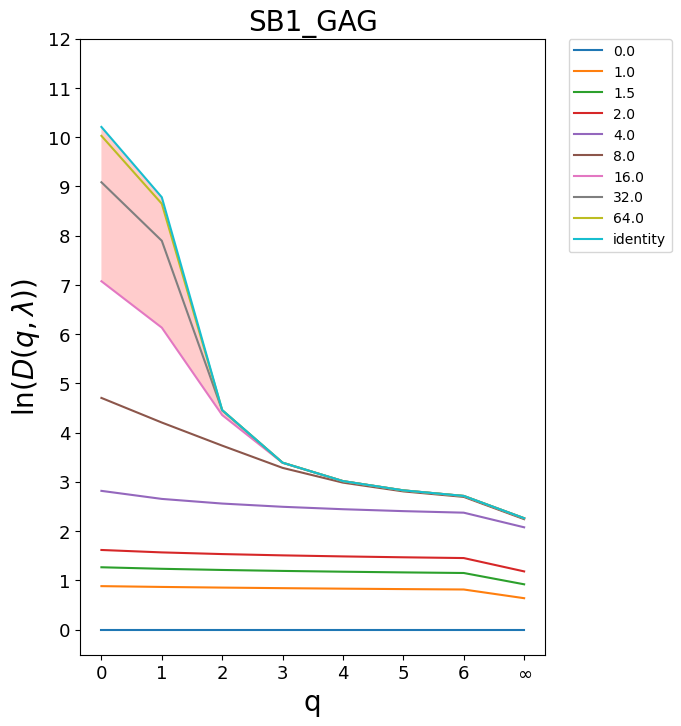

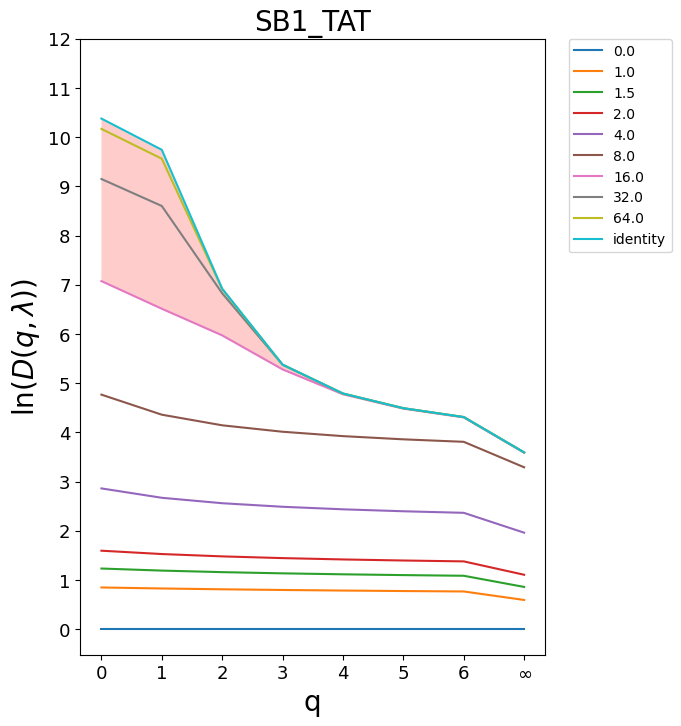

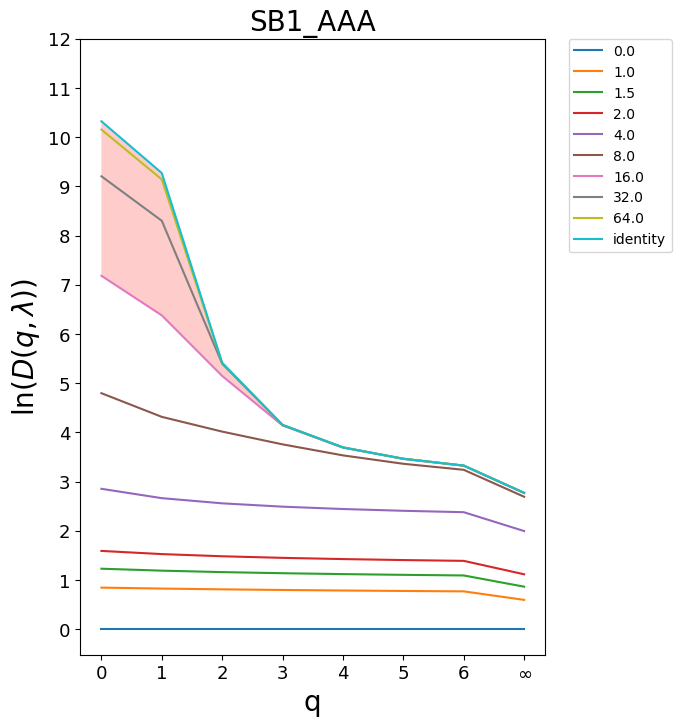

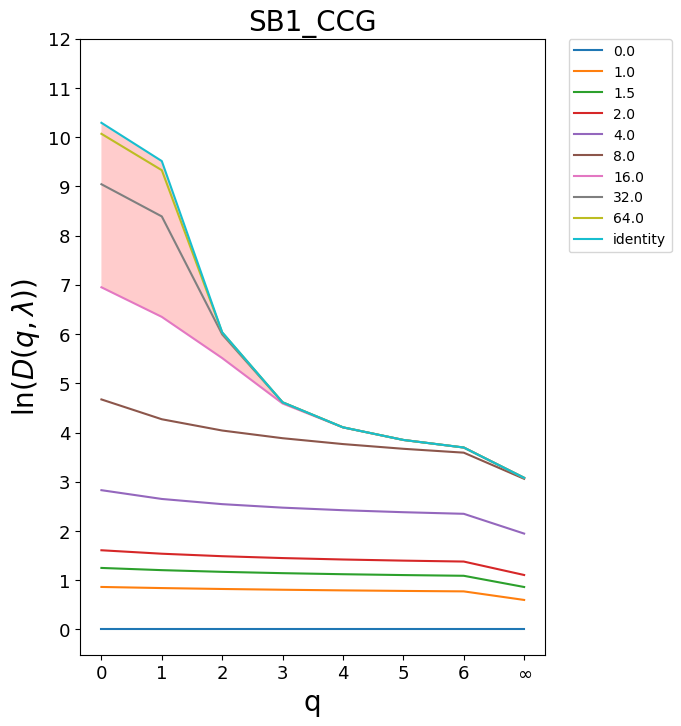

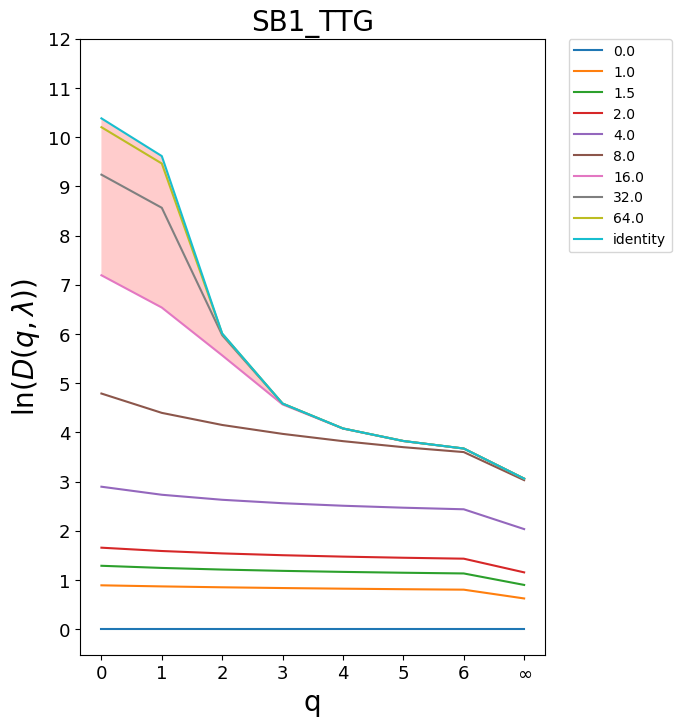

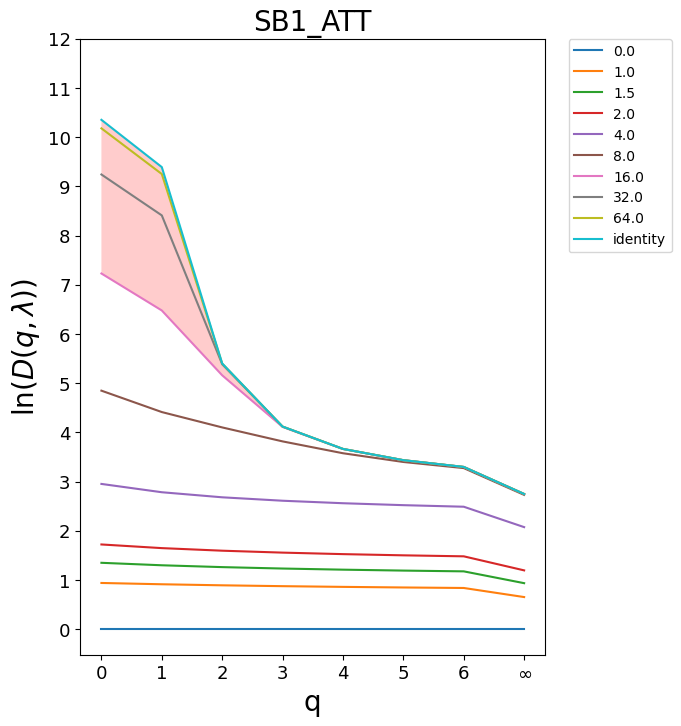

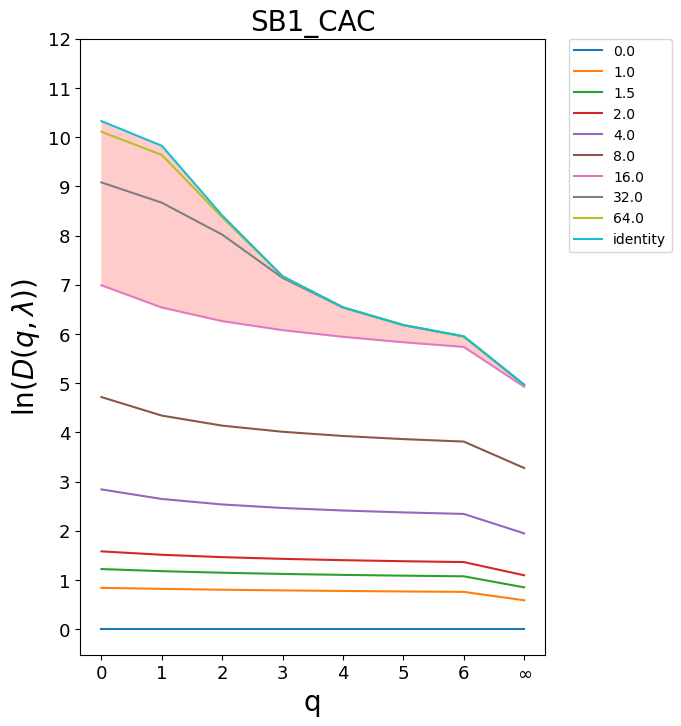

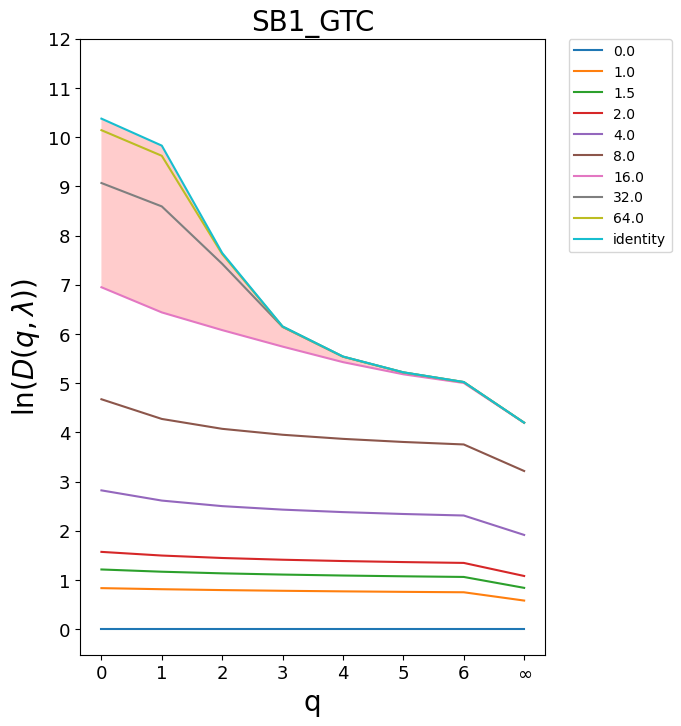

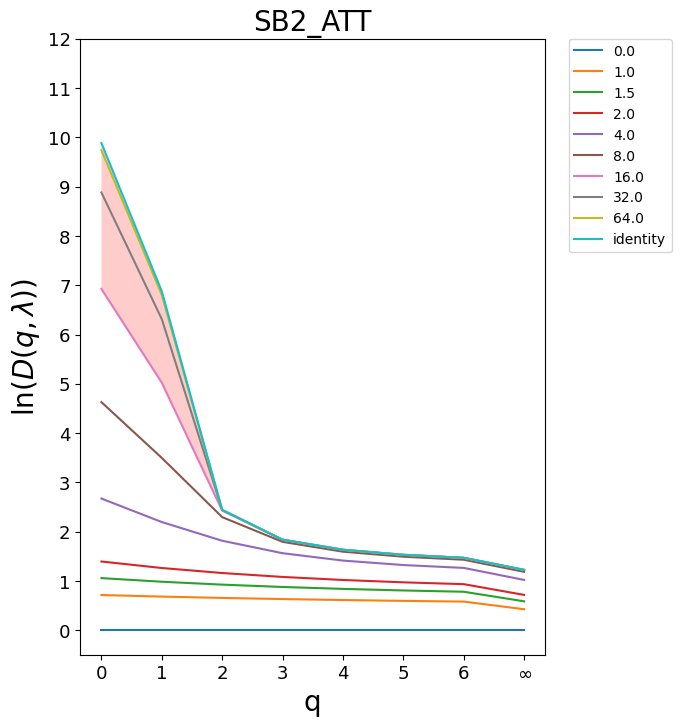

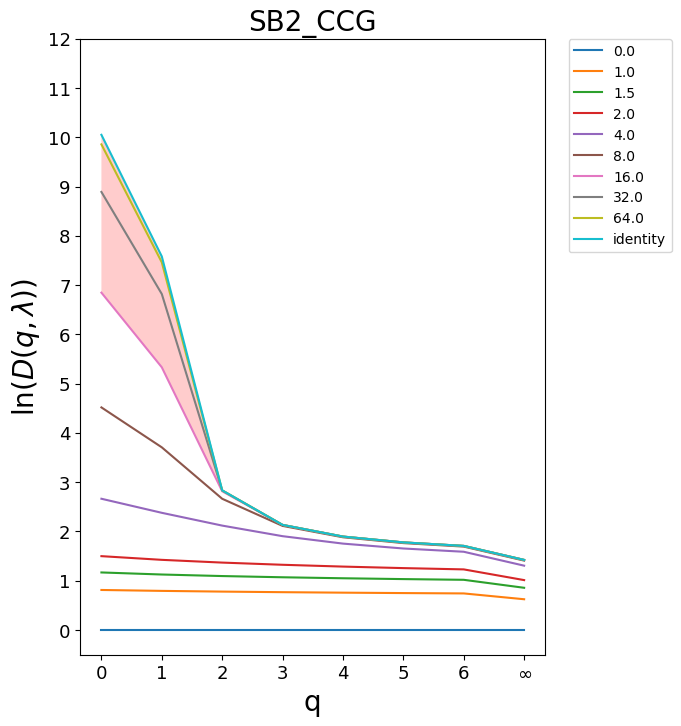

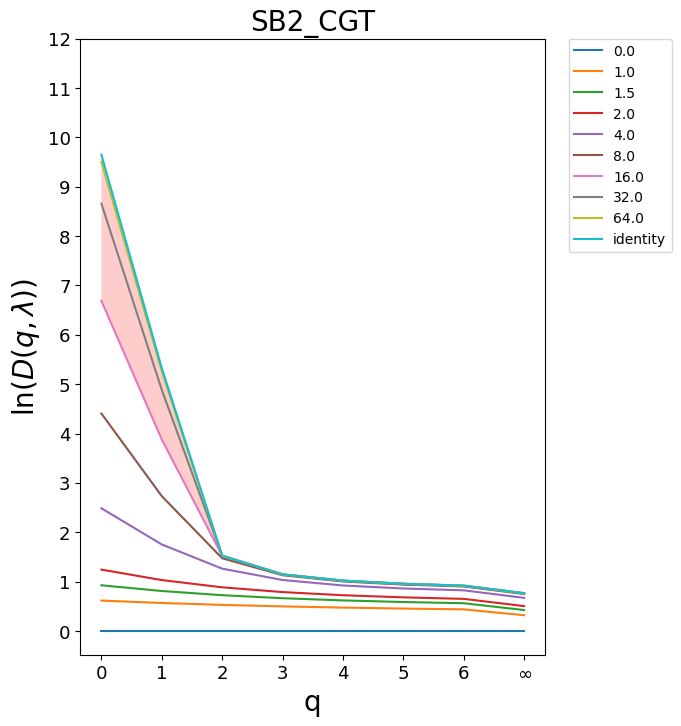

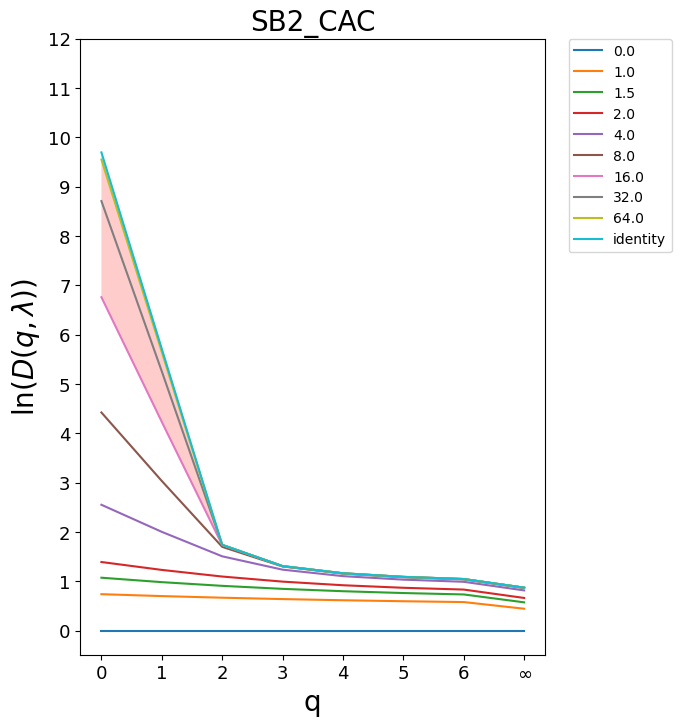

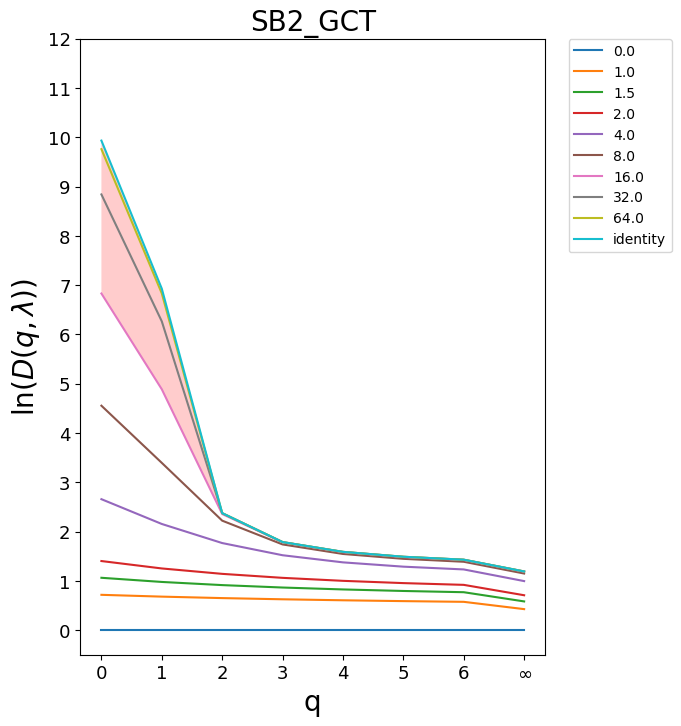

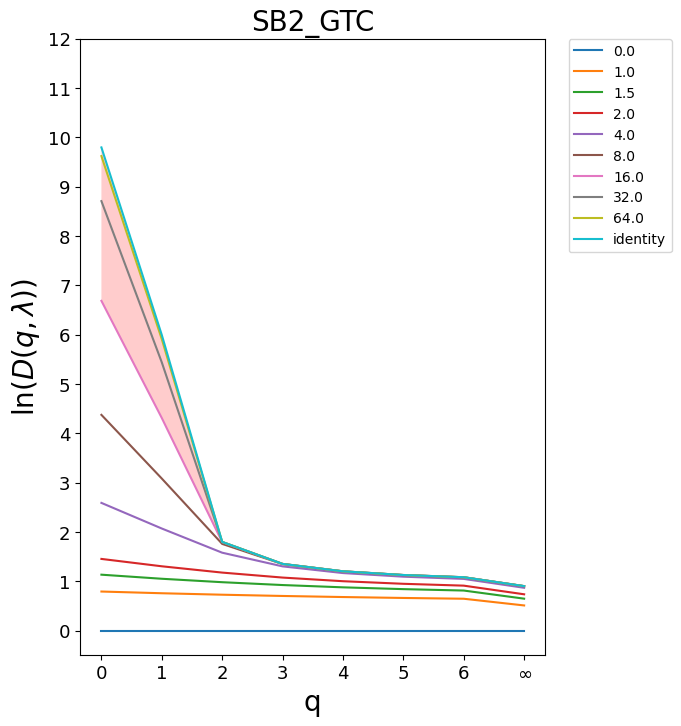

In [91]:
# define divP files 
divP_fpath = wdir_path + "divP_tsv/"
# Initiate empty list to store area dictionaries 
divP_areas = []
divP_slopes = []
average_delta_lambda = []
divP1_all_list = []
# iterate trough files 
for index,row in mddf.iterrows():
    # create pandas dataframes of divPs
    sample_name = row['sample_name'] 
    treatment = row['treatment']
    time = row['post_imm_time']
    divP_df = pd.read_csv(divP_fpath + row['sample_name'] + "_clean_cdr3_divP.tsv", comment='#', sep = '\t')
    divP_df = divP_df.set_index('q')
    divP_df.insert(0, '0.0', [1]*divP_df.shape[0])
    #ln transform the dataframe
    divP_df = np.log(divP_df)
    qs = divP_df.index.values[:-1]
    qs = np.append(qs, (divP_df.index.values[-2] + 1))
    divP_df["q"] = qs
    #calculate areas dictionary and append to a list
    divP_areas.append(calculate_area_between_curves(divP_df))
    #calculate slopes dictionary and append to a list
    divP_slopes.append(calculate_slopes(divP_df))
    ##calculate average delta lambda for small lambda: 
    average_delta_lambda.append(calculate_avg_delta_lambda_05_00(divP_df))
    #convert divP into a row df and append to a list: 
    divP1_all_list.append(make_divP_one_row_df(divP_df))
    #plot divPs
    divP_df = divP_df.drop(["0.1", "0.2", "0.25", "0.3", "0.4", "0.5", "0.75"], axis =1 )
    plt_divP(divP_df, sample_name, time, treatment, wdir_path)
    
divP_areas_df = pd.DataFrame.from_dict(divP_areas)
divP_slopes_df = pd.DataFrame.from_dict(divP_slopes)
average_delta_lambda_df = pd.DataFrame(average_delta_lambda, columns = ["Average area for small lambdas"])
divP1_all_df = pd.concat(divP1_all_list)
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df = pd.concat([divP1_all_df, mddf], axis = 1)

divP_features = pd.concat([divP_areas_df, 
                           divP_slopes_df,
                           average_delta_lambda_df, 
                           mddf], axis=1)

In [92]:
divP_features = divP_features.rename(columns={"treatment": "Treatment", "post_imm_time": "Post-immunisation Time"})

In [93]:
divP_features["Post-immunisation Time"] = divP_features['Post-immunisation Time'].str.replace('d', '')
divP_features["Post-immunisation Time"] = divP_features["Post-immunisation Time"].astype(str).astype(int)
divP_features = divP_features.sort_values('Post-immunisation Time')
divP_features = divP_features.reset_index(drop = True)
divP_features





identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.424284            2.389571            9.366182   
1             0.448165            2.512506           10.863940   
2             0.441307            2.356802            9.058862   
3             0.395162            2.061805            7.342355   
4             0.369116            1.949766            6.892452   
5             0.183637            1.081568            3.321378   
6             0.305508            1.659503            5.796937   
7             0.173277            1.187882            3.893540   
8             0.356008            2.128832            7.257564   
9             0.333495            2.212615            9.383590   
10            0.228693            1.553180            4.725906   
11            0.244184            1.657182            5.140896   
12            0.301026            1.791951            5.387567   
13            0.215459            1.547693            4.753513   
14            0.223311            1.452793            4.324143   
15            0.336161            2.138313            8.003410   
16            0.232145            1.469256            4.291161   
17            0.227150            1.431618            4.151434   
18            0.255264            1.596266            4.825708   
19            0.293848            1.851480            5.963391   
20            0.183495            1.211616            3.633262   
21            0.147596            1.067760            3.362898   
22            0.217919            1.343637            3.872622   
23            0.136202            0.938153            2.937597   
24            0.135938            0.949589            2.951125   
25            0.173087            1.100734            3.243858   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           23.487257          34.281940          41.480528   
1           25.149938          35.850794          42.954699   
2           22.954419          33.557190          40.604514   
3           19.904310          30.620056          37.802363   
4           19.221763          30.138623          37.492859   
5            6.373926          11.402660          17.908980   
6           16.657229          27.370481          34.630505   
7            9.152904          18.729824          26.387782   
8           19.032172          29.755146          36.921586   
9           23.634212          34.553958          41.826400   
10           9.486413          17.695075          25.086207   
11          10.961197          20.704198          28.108209   
12          11.414782          21.293156          28.473474   
13           9.897322          18.498121          25.827494   
14           8.236185          14.042150          21.006326   
15          21.301272          32.352619          39.698386   
16           7.997736          13.446486          20.142259   
17           7.407260          11.278941          16.684439   
18           9.962941          19.014808          26.335070   
19          14.481576          25.287747          32.621644   
20           6.571456           9.994515          13.772671   
21           6.335083           9.921289          13.852595   
22           6.880555          10.284617          14.521793   
23           5.345234           7.867992          10.467577   
24           5.383185           7.781823          10.369146   
25           5.675408           7.916837          10.393126   

    identity_1.5_area  identity_1.0_area  identity_0.75_area  \
0           43.601959          45.907572           47.144367   
1           45.038419          47.297117           48.506251   
2           42.678190          44.929833           46.137027   
3           39.923342          42.229702           43.467407   
4           39.671994          42.045793           43.321402   
5           20.121875          22.594934           23.944443   
6           36.790906          39.150370           40.421485   
7      

In [94]:
divP1_all_df = divP1_all_df.rename(columns={"treatment": "Treatment", "post_imm_time": "Post-immunisation Time"})
divP1_all_df["Post-immunisation Time"] = divP1_all_df['Post-immunisation Time'].str.replace('d', '')
divP1_all_df["Post-immunisation Time"] = divP1_all_df["Post-immunisation Time"].astype(str).astype(int)
divP1_all_df = divP1_all_df.sort_values('Post-immunisation Time')
divP1_all_df = divP1_all_df.reset_index(drop = True)
divP1_all_df


L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0    0.08906  0.088812   0.08857  0.088334  0.088104  0.087879  0.087659   
1   0.086739  0.086491  0.086249  0.086014  0.085785  0.085562  0.085344   
2   0.087098  0.086837  0.086583  0.086335  0.086094  0.085859   0.08563   
3   0.089333  0.089076  0.088825  0.088581  0.088342  0.088109  0.087882   
4   0.092167   0.09191   0.09166  0.091415  0.091176  0.090942  0.090713   
5   0.099724  0.099476  0.099234  0.098998  0.098767  0.098542  0.098322   
6   0.092774  0.092495  0.092222  0.091956  0.091696  0.091442  0.091193   
7   0.095983  0.095764  0.095549  0.095339  0.095133  0.094931  0.094733   
8   0.088565  0.088311  0.088063  0.087821  0.087585  0.087354  0.087129   
9   0.089513  0.089269  0.089029  0.088796  0.088567  0.088344  0.088125   
10   0.10169  0.101352  0.101022  0.100702  0.100389  0.100084  0.099786   
11  0.095417  0.095144  0.094877  0.094615   0.09436   0.09411  0.093865   
12  0.091954  0.091681  0.091413  0.091152  0.090896  0.090645    0.0904   
13  0.089861  0.089634  0.089413  0.089197  0.088986  0.088779  0.088577   
14  0.095589  0.095372   0.09516  0.094952  0.094747  0.094545  0.094348   
15  0.089804  0.089561  0.089324  0.089092  0.088865  0.088643  0.088425   
16  0.091346   0.09114  0.090939  0.090742  0.090549   0.09036  0.090174   
17  0.102384  0.102137  0.101895  0.101656  0.101422  0.101191  0.100964   
18  0.096726   0.09645  0.096178  0.095913  0.095652  0.095397  0.095147   
19  0.089964  0.089724   0.08949   0.08926  0.089036  0.088816  0.088602   
20  0.074381  0.074043  0.073713  0.073391  0.073078  0.072771  0.072473   
21  0.074253  0.073951  0.073655  0.073365  0.073081  0.072803   0.07253   
22  0.088165  0.087979  0.087798  0.087622   0.08745  0.087284  0.087121   
23  0.062679  0.062269   0.06187  0.061481  0.061103  0.060734  0.060375   
24  0.080497  0.080174  0.079858   0.07955   0.07925  0.078957  0.078671   
25  0.087938  0.087652  0.087373  0.087101  0.086836  0.086578  0.086327   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0     0.06334  0.176841  0.175868  ...       6.412983       6.070457   
1    0.061627  0.172292  0.171315  ...        6.71513       6.402802   
2    0.061471   0.17301  0.171981  ...       6.225713       5.923223   
3    0.063424  0.177394  0.176384  ...       5.830811        5.53916   
4    0.065311  0.182998  0.181993  ...       5.786627       5.498708   
5    0.072395  0.197514  0.196554  ...       2.928516       2.754211   
6    0.065779  0.184162  0.183066  ...       5.461566       5.184441   
7    0.068627  0.190568  0.189712  ...       4.263005       4.055372   
8    0.062705  0.175917  0.174915  ...       5.541584       5.220811   
9    0.063453  0.177789  0.176826  ...       6.543145       6.182602   
10   0.071779  0.201621  0.200299  ...       3.664288       3.435642   
11   0.067587  0.189384  0.188315  ...       4.079247       3.824624   
12   0.064951  0.182579  0.181506  ...       4.105029        3.84884   
13   0.063999  0.178527  0.177637  ...       3.696211       3.465669   
14   0.068645  0.189527   0.18869  ...       3.015706       2.827485   
15   0.063655  0.178408  0.177452  ...       6.055319       5.688548   
16   0.065608   0.18132  0.180513  ...       2.852566       2.674665   
17   0.073844   0.20229  0.201354  ...       2.381074       2.232401   
18   0.068679  0.191843  0.190767  ...       3.898265       3.661105   
19   0.063789  0.178718  0.177775  ...       4.789254       4.490918   
20   0.050605  0.148051  0.146684  ...       1.590088       1.490714   
21   0.049913  0.147812  0.146595  ...       1.635042       1.532858   
22    0.06585  0.174676  0.173934  ...        1.89572       1.777246   
23   0.039562  0.124833  0.123156  ...       1.018719       0.955052   
24   0.059174  0.159316  0.157987  ...       1.165772       1.092916   
25   0.068798  0.173625  0.172448  ...       1.201407       1.126322   

   L_

## Plot Naive diversity profile without similarity for all samples 

In [95]:
divP_identity = divP1_all_df.copy()

In [96]:
divP_identity = divP_identity[[div for div in list(divP_identity) if "identity" in div] + ["Treatment", "Post-immunisation Time", "sample_name"]]

In [97]:
divP_identity["Treatment_Time"] = divP_identity.apply( lambda row: row["Treatment"] + 
                                                      "_day_" + str(row["Post-immunisation Time"]), axis = 1)



In [98]:
divP_identity_list = []
qDzs = [div for div in list(divP_identity) if div.startswith("L")]
for index, row in divP_identity.iterrows():
    for column in qDzs:
        divP_identity_list.append([row["sample_name"], int(column.split("_")[-1]), 
                                   row[column], 
                                   row["Treatment_Time"],row["Treatment"], 
                                   row["Post-immunisation Time"]])
        
        
        

In [99]:
divP_identity_plt_df = pd.DataFrame(divP_identity_list, columns = ["sample_name", "q", "qDZ",
                                                                   "Treatment_Time", "Treatment", 
                                                                   "Post-immunisation Time"])

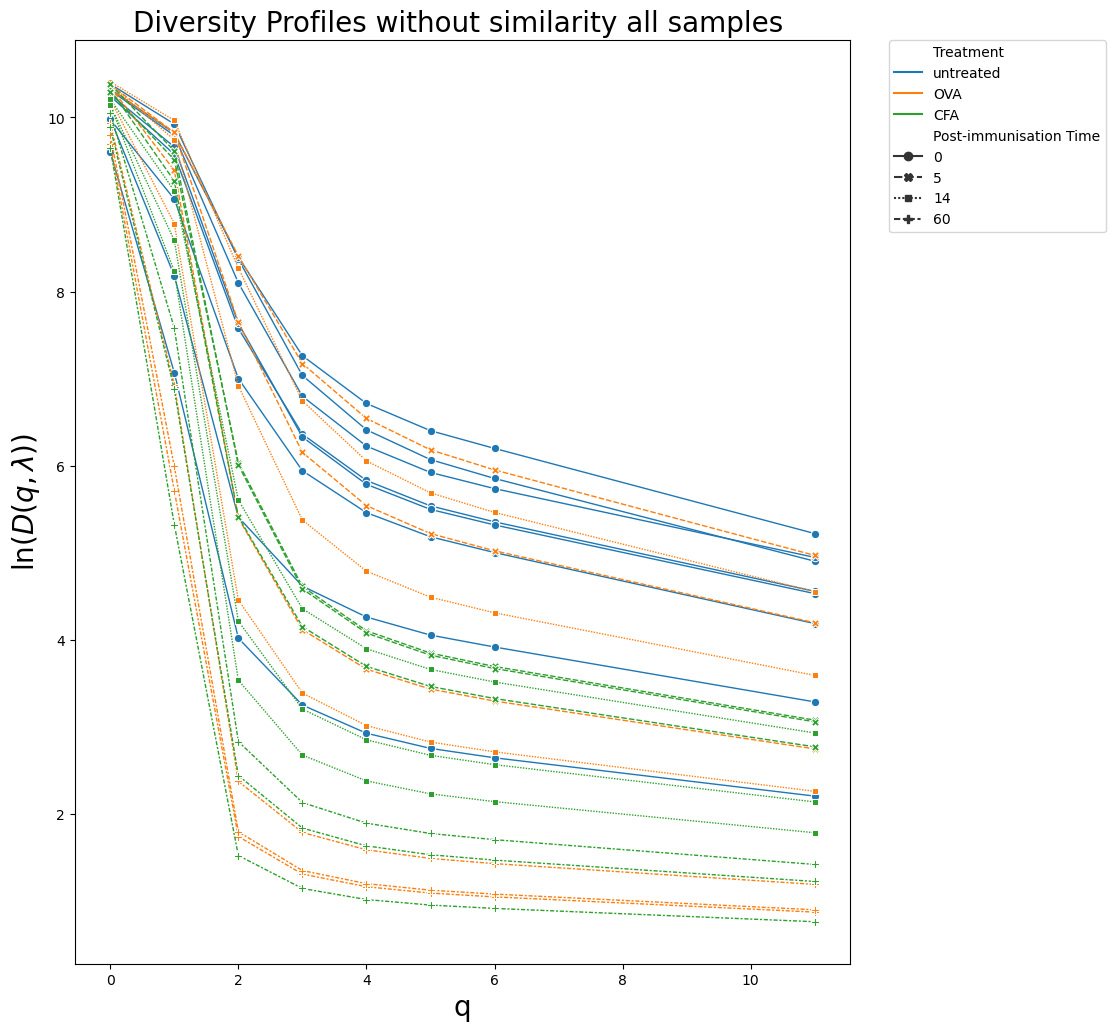

In [100]:
plt.figure(figsize=(10,12))
sns.color_palette("colorblind")
ax =sns.lineplot(data=divP_identity_plt_df, x="q", y="qDZ", hue="Treatment", style="Post-immunisation Time", units="sample_name", markers=True, estimator = None, lw=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.xlabel("q", fontsize = 20)
plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
plt.title("Diversity Profiles without similarity all samples ", fontsize = 20)
plt.savefig(wdir_path + "Diversity_profiles_ID_all_samples.png", bbox_inches='tight')
plt.show()
plt.close()
    



## All samples
### important features corrplot

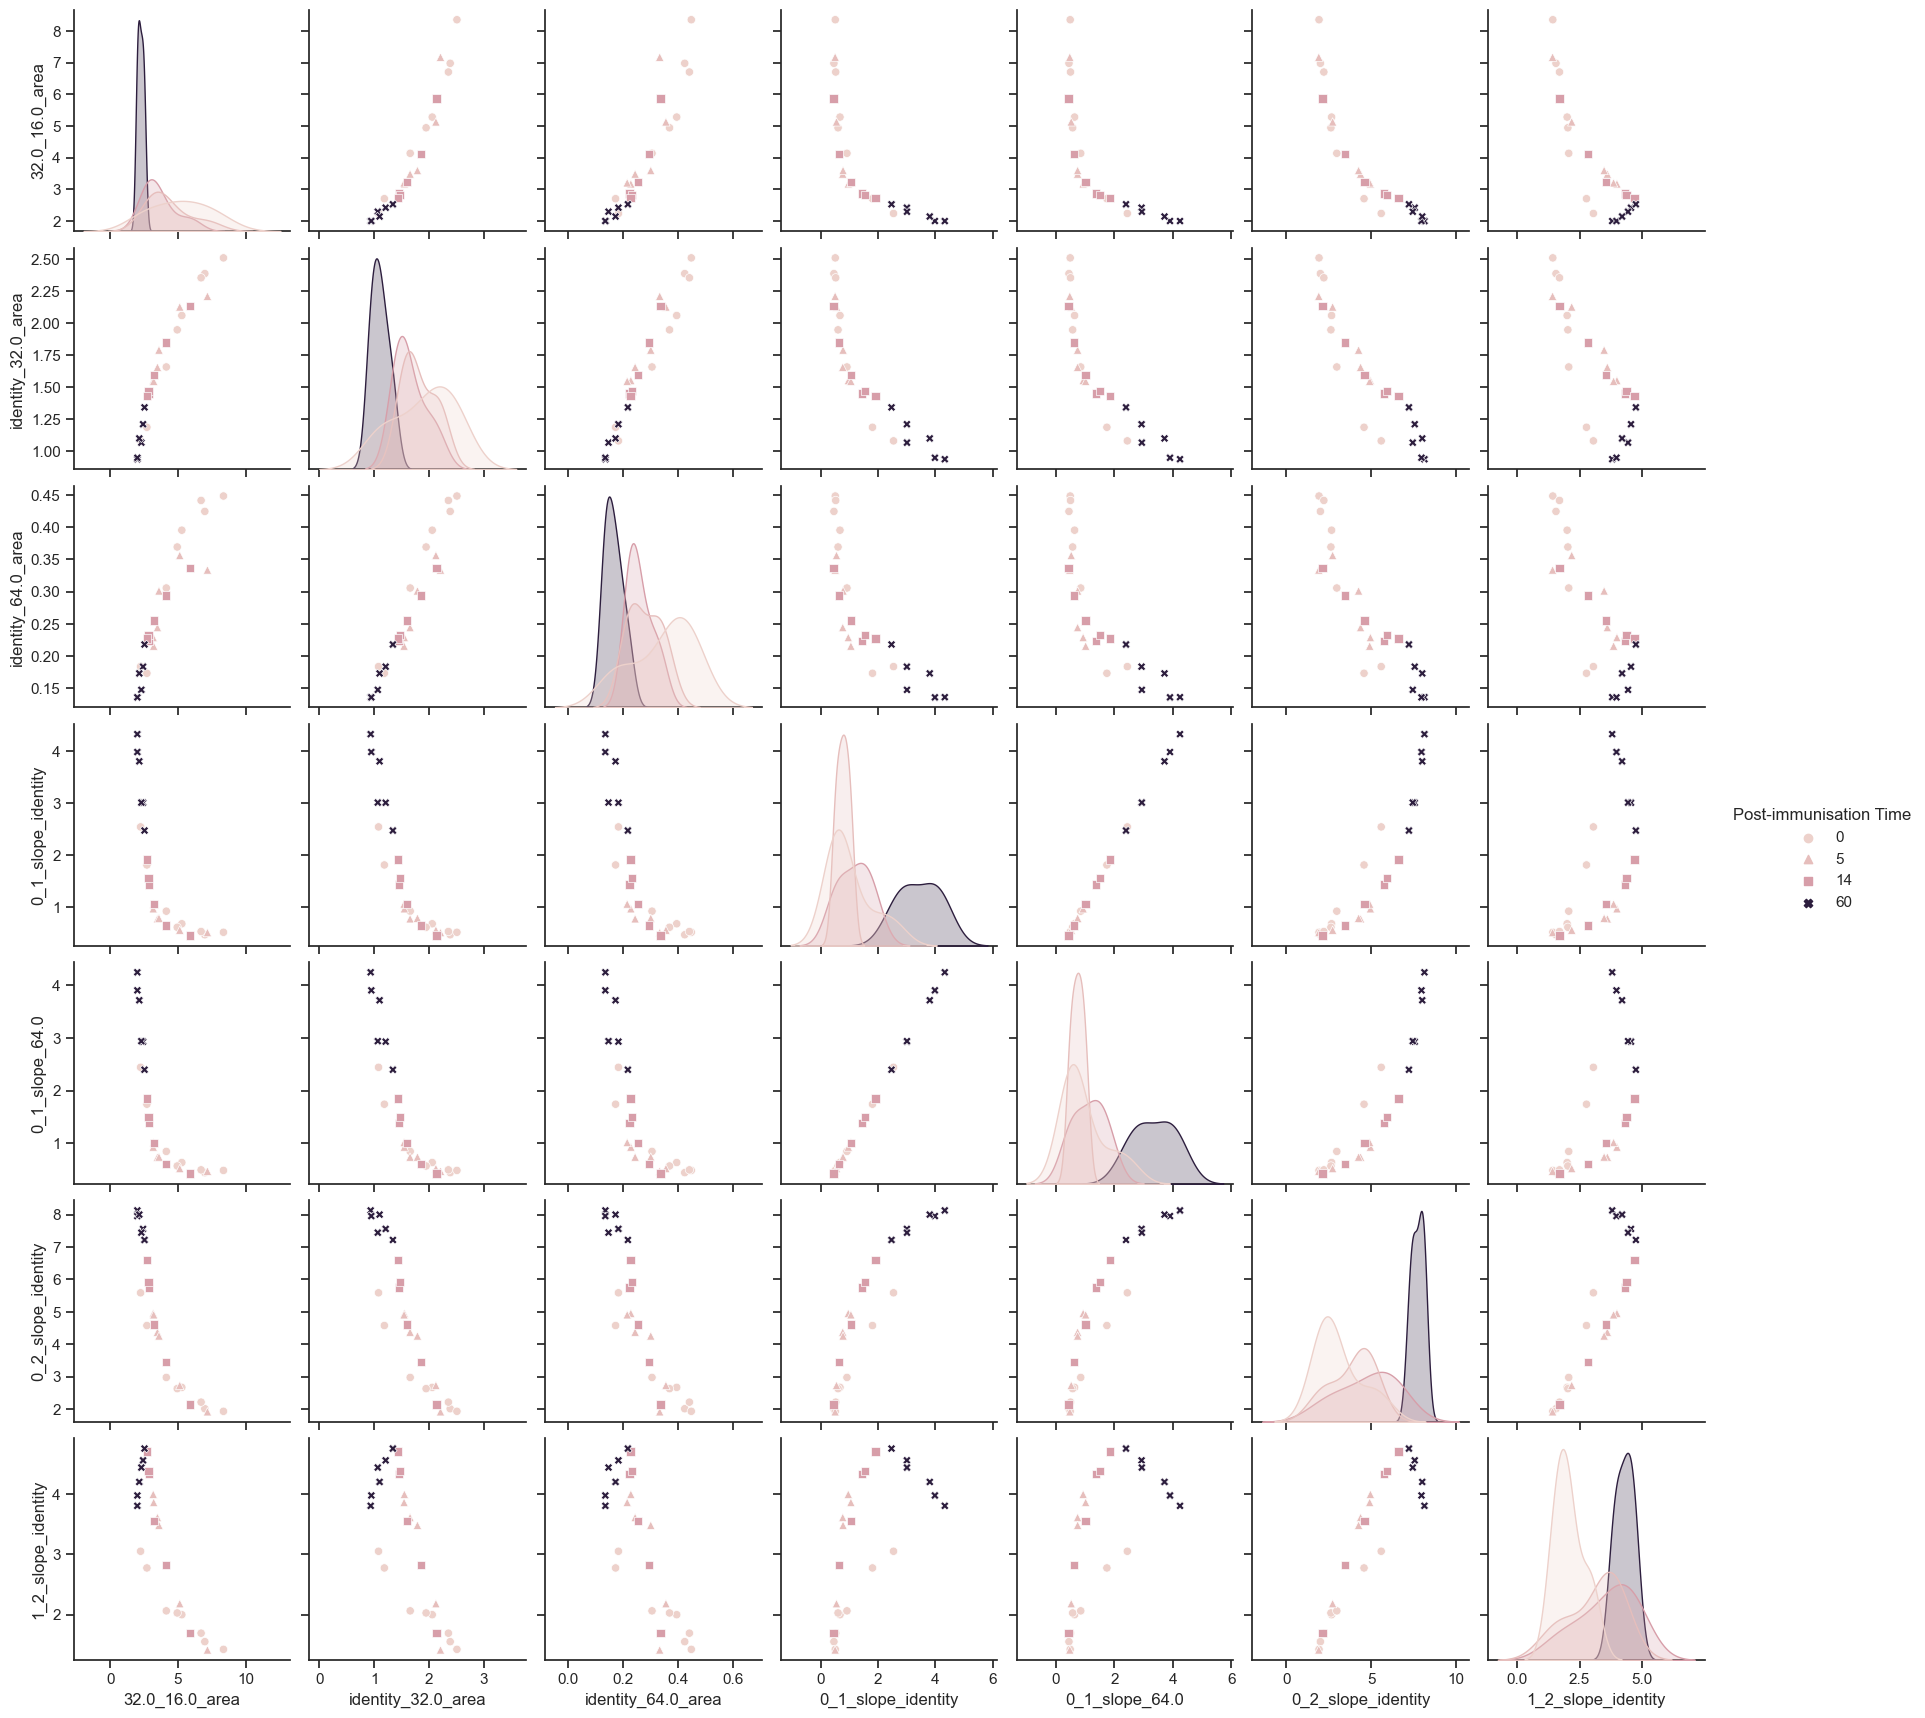

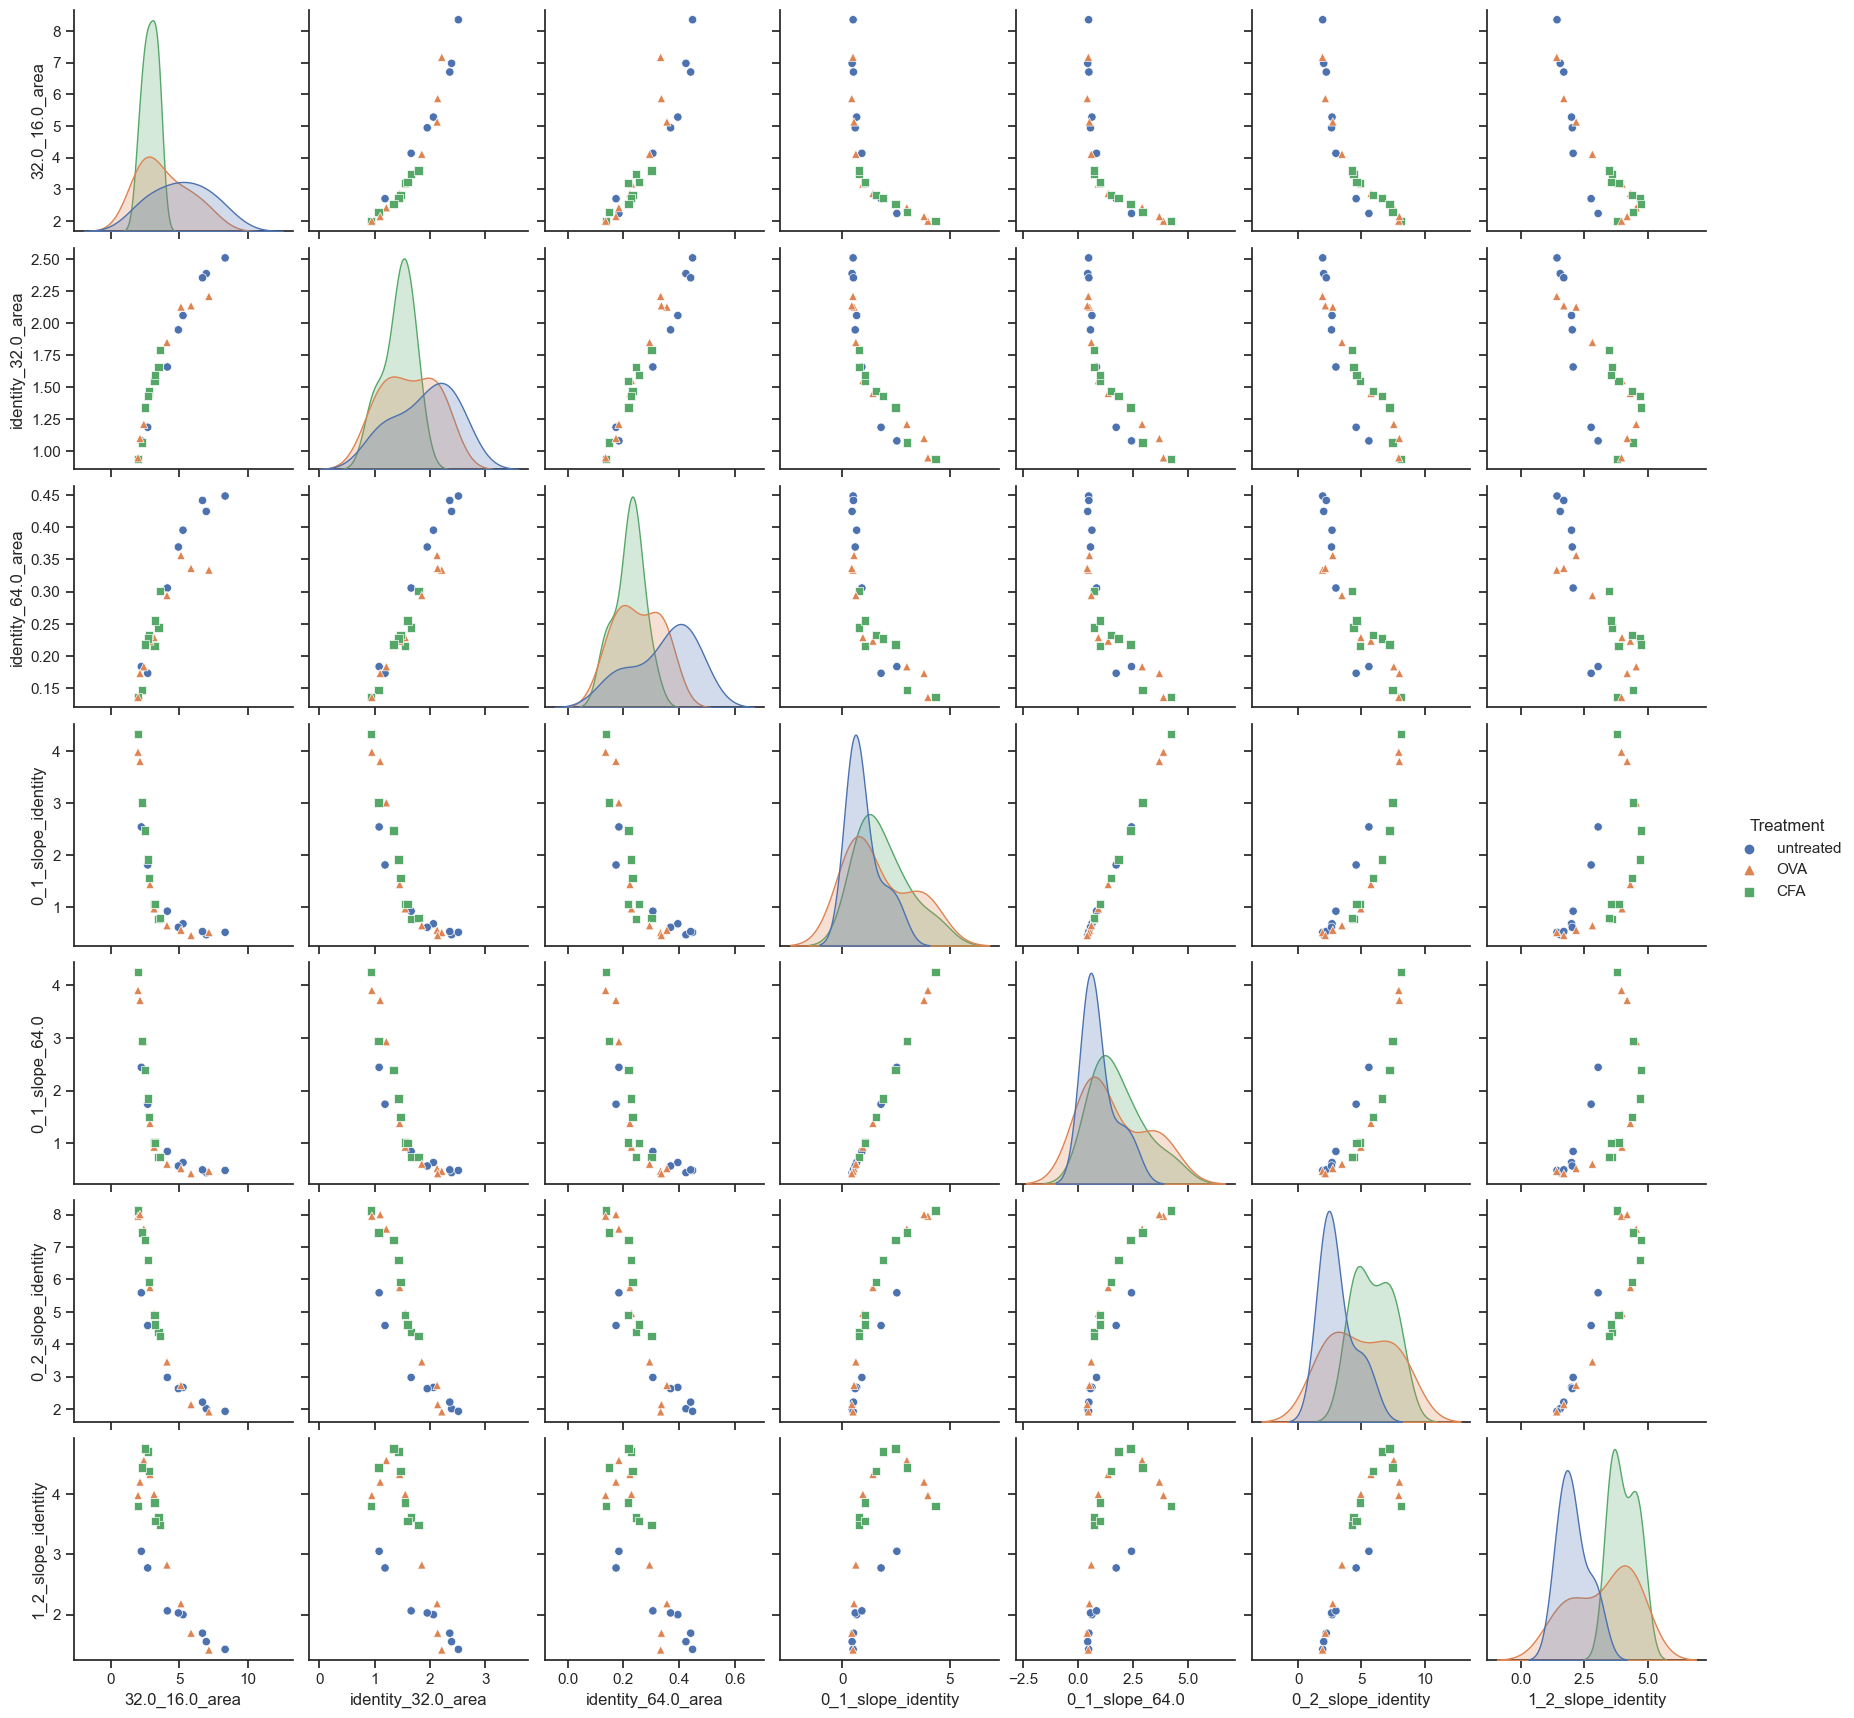

In [101]:
all_features = divP_features.copy()
important_ft = ["32.0_16.0_area", 
                "identity_32.0_area",
                "identity_64.0_area", 
                "0_1_slope_identity", 
                "0_1_slope_64.0", 
                "0_2_slope_identity", 
                "1_2_slope_identity",  
                "Treatment", 
               "Post-immunisation Time"]
divP_impr_ft = divP_features[important_ft]

sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Post-immunisation Time", markers = ["o", "^", "s", "X"])
pairplot.savefig(wdir_path + "features_pairplot_timepoint.pdf")
pairplot

divP_impr_ft = divP_impr_ft.drop(['Post-immunisation Time'], axis=1)
sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Treatment", markers = ["o", "^", "s"])
pairplot.savefig(wdir_path + "features_pairplot_treatment.pdf")
pairplot


### Selected features scatterplot 

In [102]:
def plot_selected_ft_scatterplot(ft1, ft2, hue_cat, style_cat, xlabel_f1, ylabel_ft2, wdir_path, divP_features_df, legend_opt = True):
    fig, ax = plt.subplots(figsize=(8,8))
    cmap = sns.color_palette("colorblind", len(list(set(divP_features_df[hue_cat]))))
    p = sns.scatterplot(x=ft1, y=ft2, 
                     data=divP_features_df,
                     hue=hue_cat, palette=cmap,  
                     style = style_cat, 
                     s = 140, legend = legend_opt
                     )
    if legend_opt:
        p.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(fontsize = 20, rotation=45)
    plt.yticks(fontsize = 20)
    plt.xlabel(xlabel_f1, fontsize = 26)
    plt.ylabel(ylabel_ft2, fontsize = 26)
    plt.tight_layout()
    if not os.path.isdir(wdir_path):
        os.makedirs(wdir_path, exist_ok=False)
    plt.savefig(wdir_path  + ft1 + "_" + ft2 + "_scatterplot_w_legend"+ str(legend_opt)+ ".pdf")
    plt.show()
    plt.close()


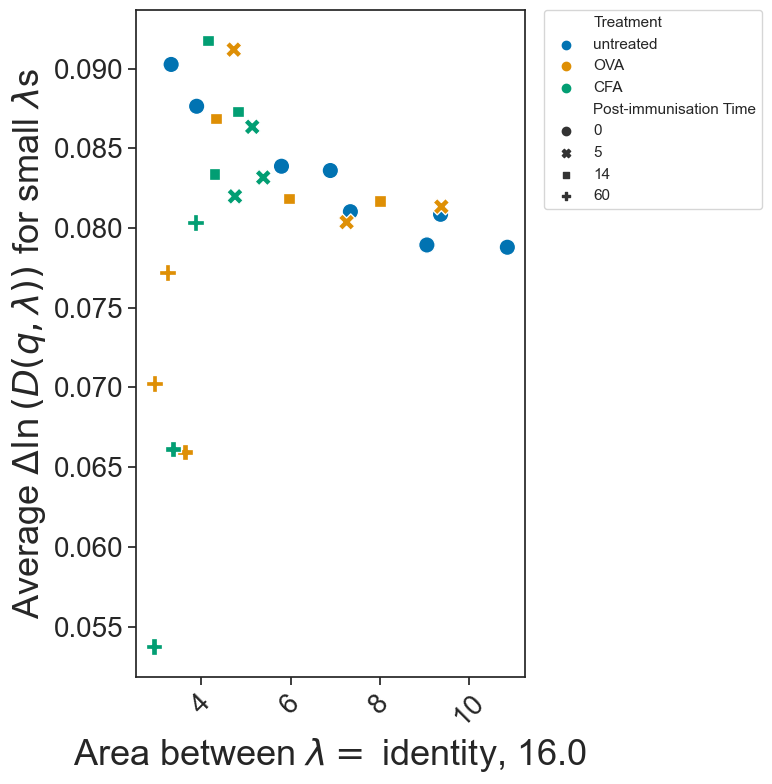

In [103]:
# delta lambda vs ID 16 area
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, True)


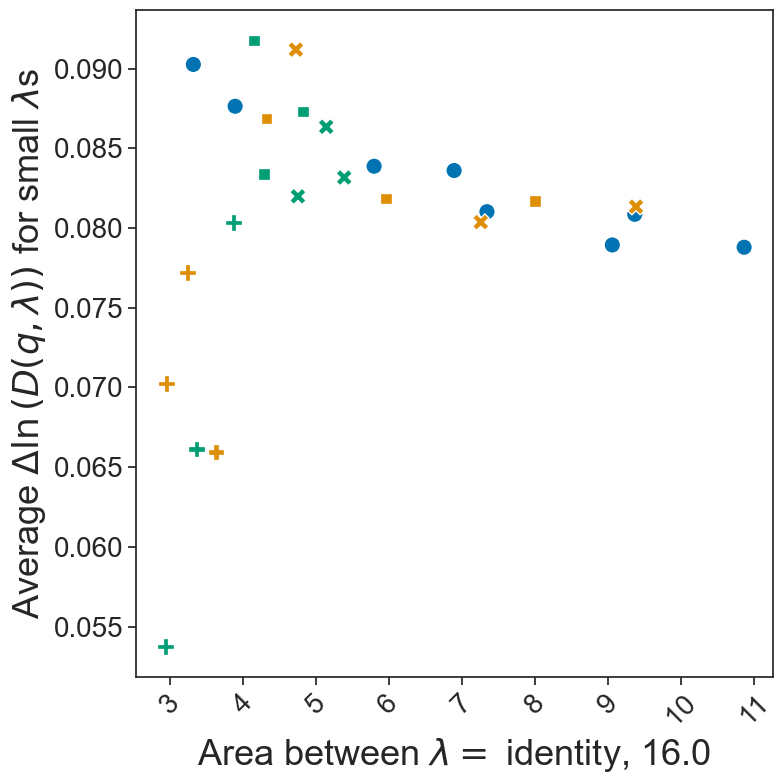

In [104]:
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


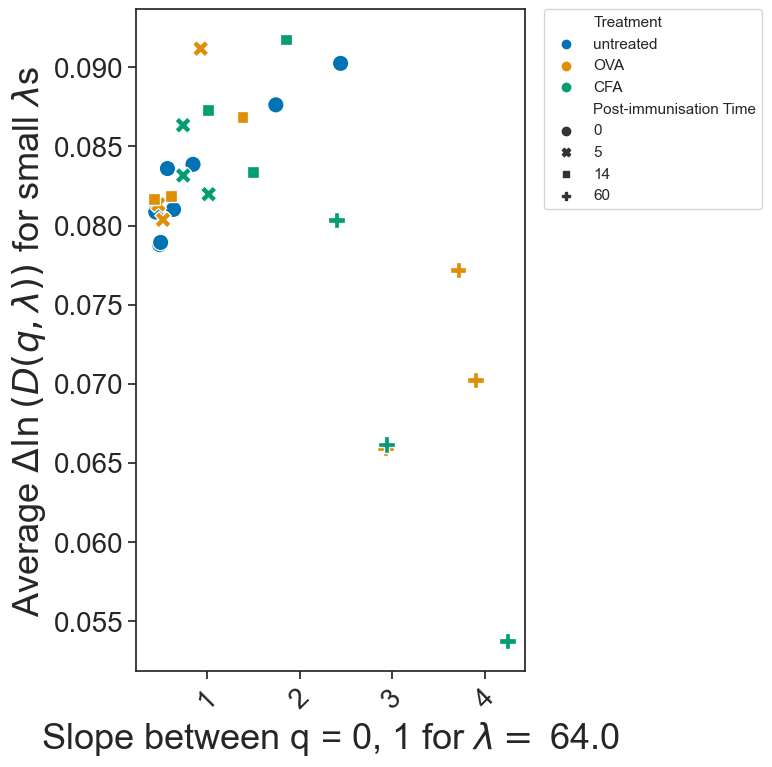

In [105]:
# delta lambda vs 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features)


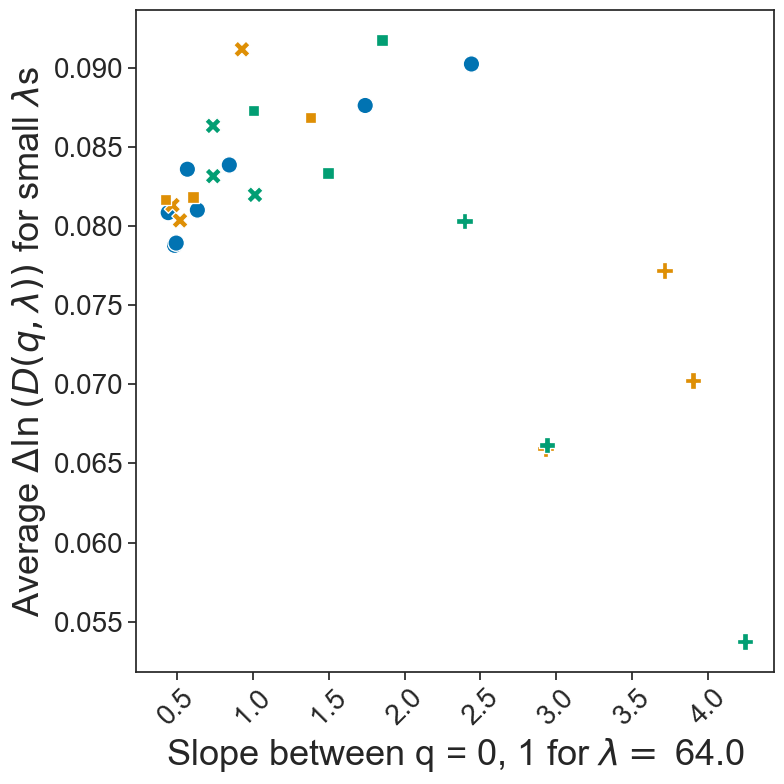

In [106]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


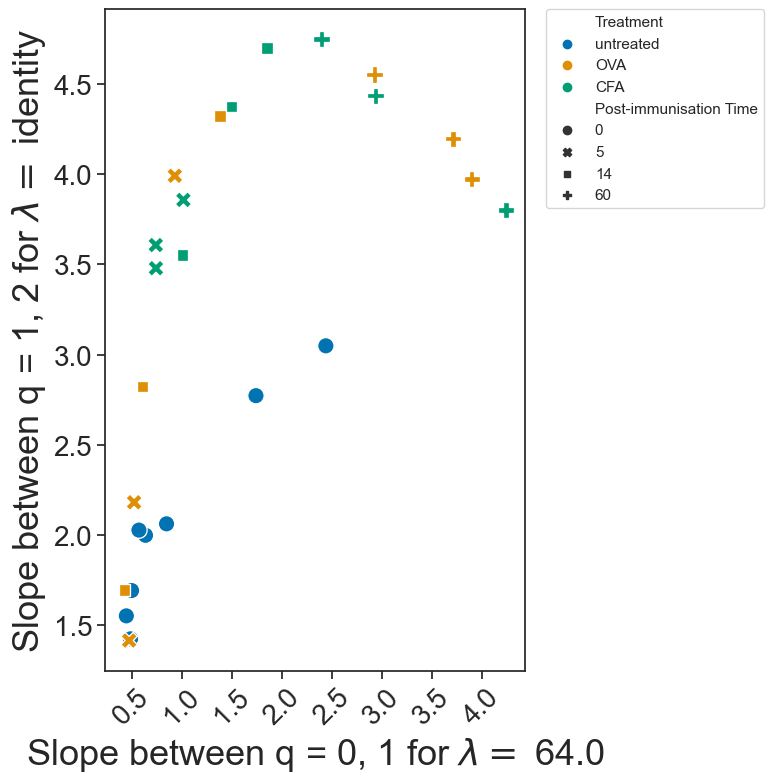

In [107]:
# 1-2 slope ID 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

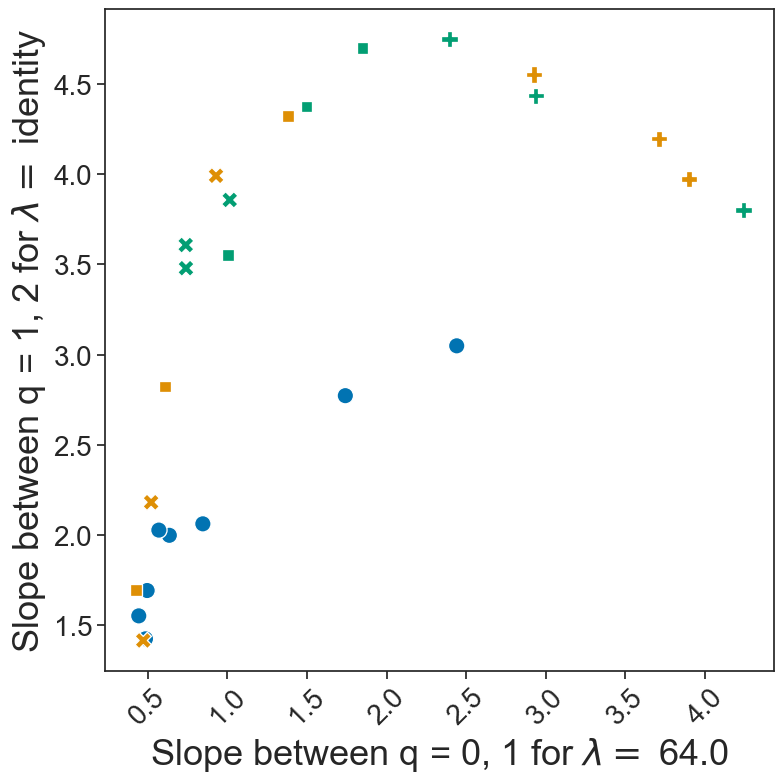

In [108]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

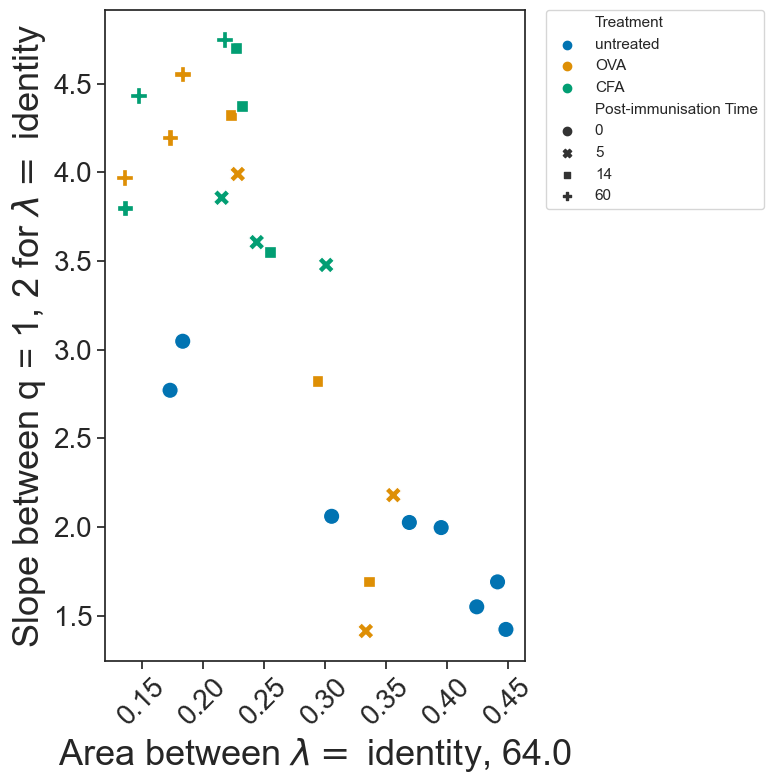

In [109]:
# 1-2 slope ID  ID 64 area

plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

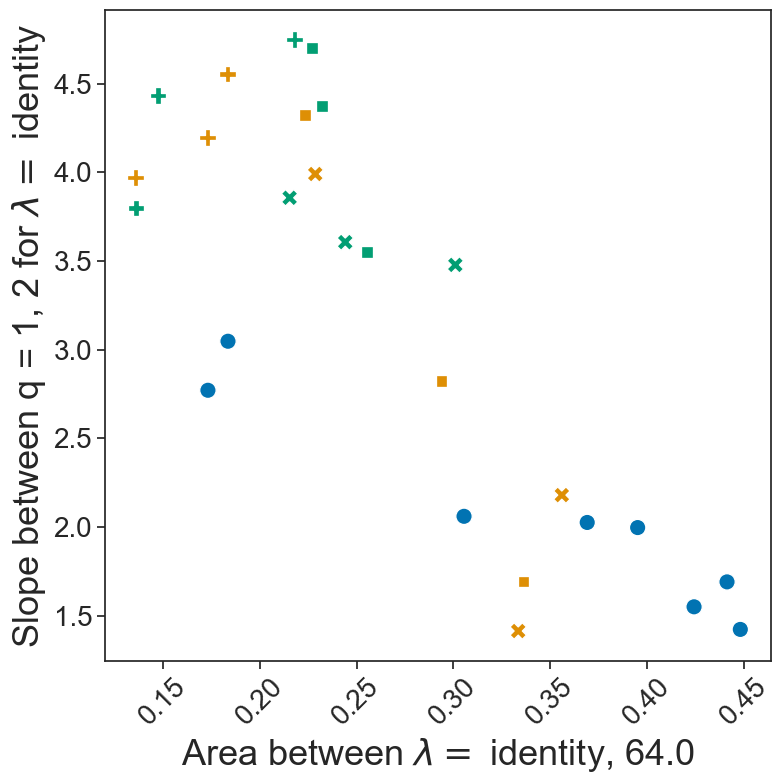

In [110]:
plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

### Lineplot of areas and slope 


In [111]:
hm_ft_df =divP_features[["sample_name", "Treatment", "Post-immunisation Time" ,"Average area for small lambdas","identity_16.0_area","0_1_slope_identity"]]

hm_ft_df["sample_name"] = [" ".join([row["Treatment"], " ", str(row["Post-immunisation Time"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
hm_ft_df["Regime"] = [" ".join([row["Treatment"], " Day ", str(row["Post-immunisation Time"])]) for index,row in hm_ft_df.iterrows()]
#hm_ft_df = hm_ft_df.set_index("sample_name")
hm_ft_df = hm_ft_df.sort_values(by=['Post-immunisation Time', "Treatment"])
hm_ft_df


/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50001/3406630853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["sample_name"] = [" ".join([row["Treatment"], " ", str(row["Post-immunisation Time"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50001/3406630853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["Regime"] = [" ".join([row["Treatment"], " Day ", str(row["Post-immunisation Time"])]) 

sample_name  Treatment  Post-immunisation Time  \
0   untreated   0   CPX1A_GGA  untreated                       0   
1   untreated   0   CPX1A_TTG  untreated                       0   
2   untreated   0   CPX1B_CAC  untreated                       0   
3   untreated   0   EAE1A_GGA  untreated                       0   
4   untreated   0   EAE1A_TTG  untreated                       0   
5   untreated   0   EAE1B_CCG  untreated                       0   
6   untreated   0   EAE1B_TTG  untreated                       0   
7     untreated   0   SB1_TGC  untreated                       0   
11          CFA   5   SB1_TTG        CFA                       5   
12          CFA   5   SB1_CCG        CFA                       5   
13          CFA   5   SB1_AAA        CFA                       5   
8           OVA   5   SB1_GTC        OVA                       5   
9           OVA   5   SB1_CAC        OVA                       5   
10          OVA   5   SB1_ATT        OVA                       5   
16         CFA   14   SB1_GCT        CFA                      14   
17         CFA   14   SB1_CTA        CFA                      14   
18         CFA   14   SB1_ACC        CFA                      14   
14         OVA   14   SB1_GAG        OVA                      14   
15         OVA   14   SB1_AGG        OVA                      14   
19         OVA   14   SB1_TAT        OVA                      14   
21         CFA   60   SB2_ATT        CFA                      60   
22         CFA   60   SB2_CCG        CFA                      60   
23         CFA   60   SB2_CGT        CFA                      60   
20         OVA   60   SB2_GCT        OVA                      60   
24         OVA   60   SB2_CAC        OVA                      60   
25         OVA   60   SB2_GTC        OVA                      60   

    Average area for small lambdas  identity_16.0_area  0_1_slope_identity  \
0                         0.080857            9.366182            0.458929   
1                         0.078792           10.863940            0.506346   
2                         0.078934            9.058862            0.521180   
3                         0.081022            7.342355            0.670751   
4                         0.083603            6.892452            0.602844   
5                         0.090256            3.321378            2.538272   
6                         0.083872            5.796937            0.913521   
7                         0.087633            3.893540            1.804625   
11                        0.086345            5.140896            0.766652   
12                        0.083165            5.387567            0.777599   
13                        0.081984            4.753513            1.051514   
8                         0.080368            7.257564            0.548493   
9                         0.081338            9.383590            0.501338   
10                        0.091185            4.725906            0.960511   
16                        0.083376            4.291161            1.554332   
17                        0.091769            4.151434            1.907772   
18                        0.087309            4.825708            1.052432   
14                        0.086877            4.324143            1.427659   
15                        0.081688            8.003410            0.444642   
19                        0.081860            5.963391            0.634549   
21                        0.066152            3.362898            3.007367   
22                        0.080344            3.872622            2.468219   
23                        0.053743            2.937597            4.326891   
20                        0.065946            3.633262            3.004399   
24                        0.070238            2.951125            3.981984   
25                        0.077199            3.243858            3.802963   

               Regime  
0   untreated  Day  0  
1   untreated  Day  0  
2 

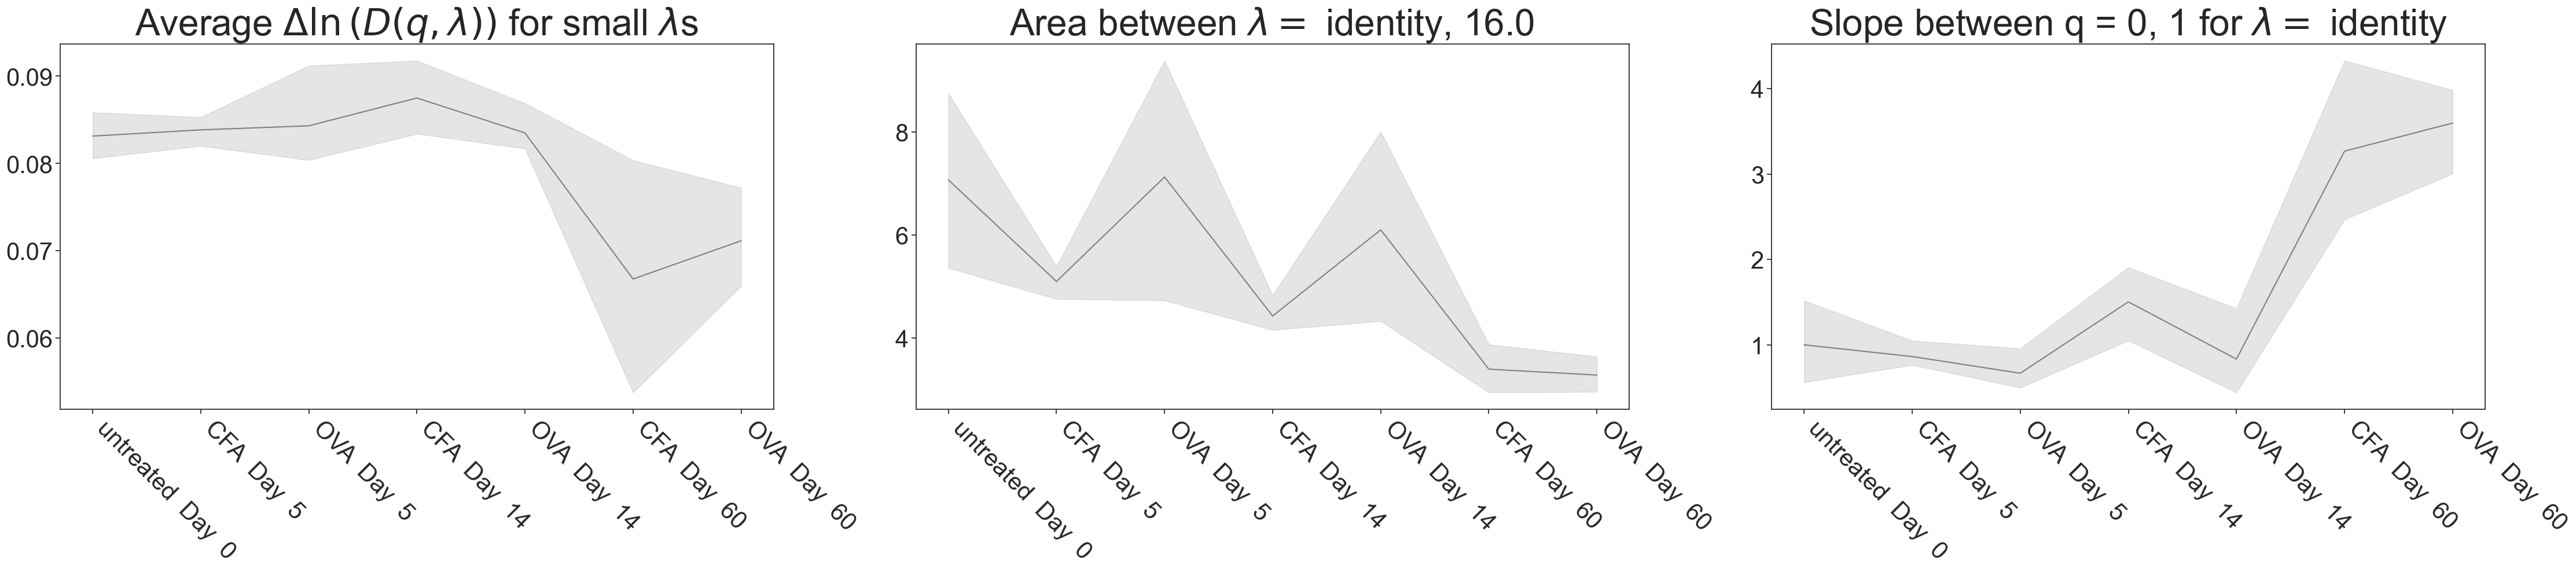

In [112]:
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.rc('axes', labelsize=46) 

fig, ax = plt.subplots(1, 3, figsize=(45, 10), sharey=False, sharex = True)
p1 = sns.lineplot(x="Regime", y="Average area for small lambdas", data=hm_ft_df, sort=False, ax=ax[0], color = "gray")
p2 = sns.lineplot(x="Regime", y="identity_16.0_area", data=hm_ft_df, sort=False, ax=ax[1], color = "gray")
p3 = sns.lineplot(x="Regime", y="0_1_slope_identity", data=hm_ft_df, sort=False, ax=ax[2], color = "gray")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

p1.set_title('Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s', fontsize = 46)
p2.set_title('Area between $\lambda =$ identity, 16.0 ', fontsize = 46)
p3.set_title('Slope between q = 0, 1 for $\lambda =$ identity', fontsize = 46)

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=-45, ha="left")

plt.tight_layout()

plt.savefig(wdir_path + "lineplot_areas_slope.pdf")

### PCA on features 

In [113]:
post_imm_time_df = divP_features["Post-immunisation Time"]
treatment_df = divP_features["Treatment"]
sample_names_df = divP_features["sample_name"]

In [114]:
divP_features_treatment_time = divP_features.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"], axis=1)

divP_features_treatment_time

identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.424284            2.389571            9.366182   
1             0.448165            2.512506           10.863940   
2             0.441307            2.356802            9.058862   
3             0.395162            2.061805            7.342355   
4             0.369116            1.949766            6.892452   
5             0.183637            1.081568            3.321378   
6             0.305508            1.659503            5.796937   
7             0.173277            1.187882            3.893540   
8             0.356008            2.128832            7.257564   
9             0.333495            2.212615            9.383590   
10            0.228693            1.553180            4.725906   
11            0.244184            1.657182            5.140896   
12            0.301026            1.791951            5.387567   
13            0.215459            1.547693            4.753513   
14            0.223311            1.452793            4.324143   
15            0.336161            2.138313            8.003410   
16            0.232145            1.469256            4.291161   
17            0.227150            1.431618            4.151434   
18            0.255264            1.596266            4.825708   
19            0.293848            1.851480            5.963391   
20            0.183495            1.211616            3.633262   
21            0.147596            1.067760            3.362898   
22            0.217919            1.343637            3.872622   
23            0.136202            0.938153            2.937597   
24            0.135938            0.949589            2.951125   
25            0.173087            1.100734            3.243858   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           23.487257          34.281940          41.480528   
1           25.149938          35.850794          42.954699   
2           22.954419          33.557190          40.604514   
3           19.904310          30.620056          37.802363   
4           19.221763          30.138623          37.492859   
5            6.373926          11.402660          17.908980   
6           16.657229          27.370481          34.630505   
7            9.152904          18.729824          26.387782   
8           19.032172          29.755146          36.921586   
9           23.634212          34.553958          41.826400   
10           9.486413          17.695075          25.086207   
11          10.961197          20.704198          28.108209   
12          11.414782          21.293156          28.473474   
13           9.897322          18.498121          25.827494   
14           8.236185          14.042150          21.006326   
15          21.301272          32.352619          39.698386   
16           7.997736          13.446486          20.142259   
17           7.407260          11.278941          16.684439   
18           9.962941          19.014808          26.335070   
19          14.481576          25.287747          32.621644   
20           6.571456           9.994515          13.772671   
21           6.335083           9.921289          13.852595   
22           6.880555          10.284617          14.521793   
23           5.345234           7.867992          10.467577   
24           5.383185           7.781823          10.369146   
25           5.675408           7.916837          10.393126   

    identity_1.5_area  identity_1.0_area  identity_0.75_area  \
0           43.601959          45.907572           47.144367   
1           45.038419          47.297117           48.506251   
2           42.678190          44.929833           46.137027   
3           39.923342          42.229702           43.467407   
4           39.671994          42.045793           43.321402   
5           20.121875          22.594934           23.944443   
6           36.790906          39.150370           40.421485   
7      

In [115]:
divP_features_treatment_time.shape

(26, 187)

In [116]:
observables = [col for col in list(divP_features_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x = divP_features_treatment_time.loc[:, observables].values
# Separating out the target
y = divP_features_treatment_time.loc[:,'Treatment'].values

In [117]:
x.shape

(26, 185)

In [118]:
x.mean(), x.std()

(11.292647457671643, 13.741331735872382)

In [119]:
x_scaled = StandardScaler().fit_transform(x)

In [120]:
x_scaled.mean(), x_scaled.std()

(-4.5978467048925404e-17, 1.0)

In [121]:
pca_scaled = decomposition.PCA(n_components=26)
principalComponents_scaled = pca_scaled.fit_transform(x_scaled)

principalDf_scaled = pd.DataFrame(data = principalComponents_scaled)
principalDf_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_scaled)]
finalDf_scaled = pd.concat([principalDf_scaled, divP_features_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



In [122]:
def plotPCA(pca_scaled, colour_category, style_category, final_Df, wdir_path, fig_name, legend):
    """
    INPUT:  pca_scaled: pca object
            colour_category: string denoting a categorical var to colour by
            style_category: string denoting a categorical var for the point shape 
            final_Df: DataFrame with principal components and categorical variables
            wdir_path: path to working directory
            fig_name: string for figure name, ending with the extension pdf or png
            legend: True or False
            
    OUTPUT: 
            PCA figure with the aspect ratio corresponding to the principal components values 
    """
    per_PC1 = int(round(pca_scaled.explained_variance_ratio_[0]*100, 0))
    per_PC2 = int(round(pca_scaled.explained_variance_ratio_[1]*100, 0))
    if per_PC1 != 0 and per_PC2 != 0:
        fig, ax = plt.subplots(figsize=(per_PC1/5,per_PC2/5))
    else: 
        fig, ax = plt.subplots(figsize=(20,1))
    cmap = sns.color_palette("colorblind", len(list(set(final_Df[colour_category]))))
    if legend == True: 
        legend_box = "full"
    else: 
        legend_box = False
    p = sns.scatterplot(x="PC_0", y="PC_1",
                     hue=colour_category, style = style_category,
                     palette=cmap, s=100,
                     data=final_Df, 
                     alpha = 1, legend = legend_box)
    if legend == True: 
        p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tick_params(axis='both',          # changes apply which axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    left = False,
                    right = False,
                    labelbottom=False,
                    labelleft = False) # labels along the bottom edge are off
    #plt.xticks(fontsize = 13)
    #plt.yticks(fontsize = 13)
    plt.xlabel("".join(["PC1 (",str(per_PC1),"%)"]), fontsize = 15)
    plt.ylabel("".join(["PC2 (",str(per_PC2),"%)"]), fontsize = 15)
    plt.tight_layout()
    plt.savefig(wdir_path + fig_name, bbox_inches='tight')

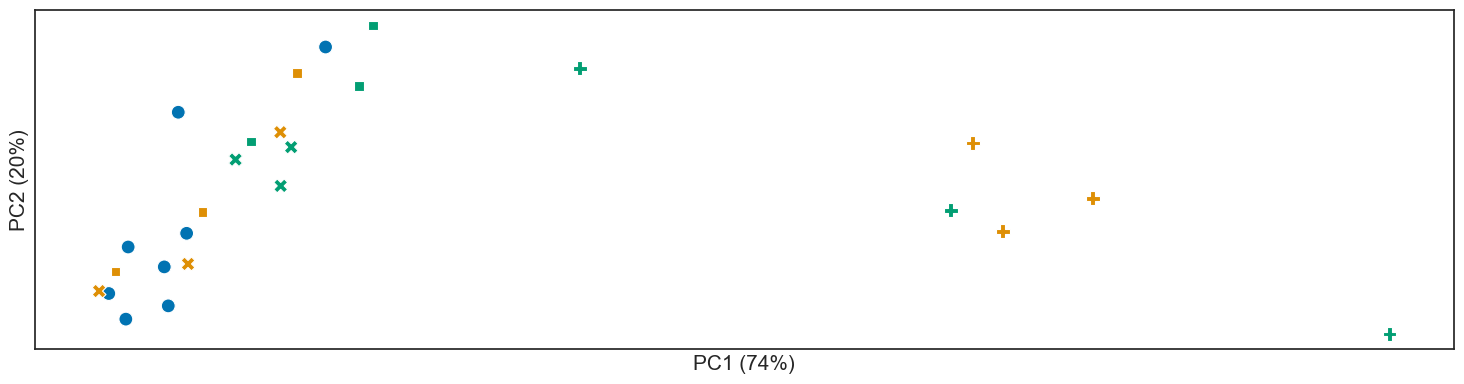

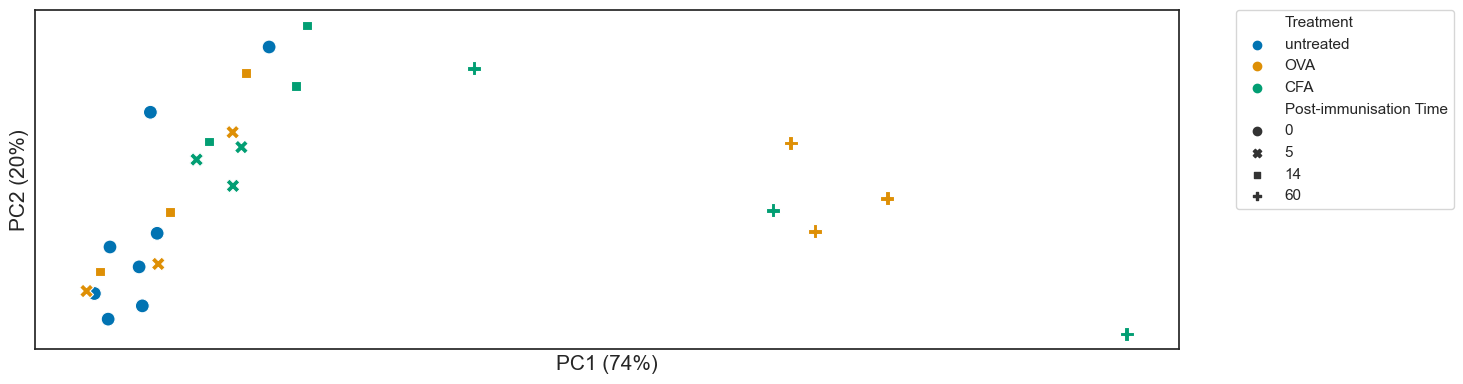

In [123]:
plotPCA(pca_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_scaled, wdir_path, "PCA_features.pdf", False)


plotPCA(pca_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_scaled, wdir_path, "PCA_features_w_legend.pdf", True)




### PCA on $D(q,\lambda)$

In [124]:
# remove PBS
divP1_all_df = divP1_all_df[divP1_all_df.Treatment != "PBS"]
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0    0.08906  0.088812   0.08857  0.088334  0.088104  0.087879  0.087659   
1   0.086739  0.086491  0.086249  0.086014  0.085785  0.085562  0.085344   
2   0.087098  0.086837  0.086583  0.086335  0.086094  0.085859   0.08563   
3   0.089333  0.089076  0.088825  0.088581  0.088342  0.088109  0.087882   
4   0.092167   0.09191   0.09166  0.091415  0.091176  0.090942  0.090713   
5   0.099724  0.099476  0.099234  0.098998  0.098767  0.098542  0.098322   
6   0.092774  0.092495  0.092222  0.091956  0.091696  0.091442  0.091193   
7   0.095983  0.095764  0.095549  0.095339  0.095133  0.094931  0.094733   
8   0.088565  0.088311  0.088063  0.087821  0.087585  0.087354  0.087129   
9   0.089513  0.089269  0.089029  0.088796  0.088567  0.088344  0.088125   
10   0.10169  0.101352  0.101022  0.100702  0.100389  0.100084  0.099786   
11  0.095417  0.095144  0.094877  0.094615   0.09436   0.09411  0.093865   
12  0.091954  0.091681  0.091413  0.091152  0.090896  0.090645    0.0904   
13  0.089861  0.089634  0.089413  0.089197  0.088986  0.088779  0.088577   
14  0.095589  0.095372   0.09516  0.094952  0.094747  0.094545  0.094348   
15  0.089804  0.089561  0.089324  0.089092  0.088865  0.088643  0.088425   
16  0.091346   0.09114  0.090939  0.090742  0.090549   0.09036  0.090174   
17  0.102384  0.102137  0.101895  0.101656  0.101422  0.101191  0.100964   
18  0.096726   0.09645  0.096178  0.095913  0.095652  0.095397  0.095147   
19  0.089964  0.089724   0.08949   0.08926  0.089036  0.088816  0.088602   
20  0.074381  0.074043  0.073713  0.073391  0.073078  0.072771  0.072473   
21  0.074253  0.073951  0.073655  0.073365  0.073081  0.072803   0.07253   
22  0.088165  0.087979  0.087798  0.087622   0.08745  0.087284  0.087121   
23  0.062679  0.062269   0.06187  0.061481  0.061103  0.060734  0.060375   
24  0.080497  0.080174  0.079858   0.07955   0.07925  0.078957  0.078671   
25  0.087938  0.087652  0.087373  0.087101  0.086836  0.086578  0.086327   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0     0.06334  0.176841  0.175868  ...       6.412983       6.070457   
1    0.061627  0.172292  0.171315  ...        6.71513       6.402802   
2    0.061471   0.17301  0.171981  ...       6.225713       5.923223   
3    0.063424  0.177394  0.176384  ...       5.830811        5.53916   
4    0.065311  0.182998  0.181993  ...       5.786627       5.498708   
5    0.072395  0.197514  0.196554  ...       2.928516       2.754211   
6    0.065779  0.184162  0.183066  ...       5.461566       5.184441   
7    0.068627  0.190568  0.189712  ...       4.263005       4.055372   
8    0.062705  0.175917  0.174915  ...       5.541584       5.220811   
9    0.063453  0.177789  0.176826  ...       6.543145       6.182602   
10   0.071779  0.201621  0.200299  ...       3.664288       3.435642   
11   0.067587  0.189384  0.188315  ...       4.079247       3.824624   
12   0.064951  0.182579  0.181506  ...       4.105029        3.84884   
13   0.063999  0.178527  0.177637  ...       3.696211       3.465669   
14   0.068645  0.189527   0.18869  ...       3.015706       2.827485   
15   0.063655  0.178408  0.177452  ...       6.055319       5.688548   
16   0.065608   0.18132  0.180513  ...       2.852566       2.674665   
17   0.073844   0.20229  0.201354  ...       2.381074       2.232401   
18   0.068679  0.191843  0.190767  ...       3.898265       3.661105   
19   0.063789  0.178718  0.177775  ...       4.789254       4.490918   
20   0.050605  0.148051  0.146684  ...       1.590088       1.490714   
21   0.049913  0.147812  0.146595  ...       1.635042       1.532858   
22    0.06585  0.174676  0.173934  ...        1.89572       1.777246   
23   0.039562  0.124833  0.123156  ...       1.018719       0.955052   
24   0.059174  0.159316  0.157987  ...       1.165772       1.092916   
25   0.068798  0.173625  0.172448  ...       1.201407       1.126322   

   L_

In [125]:
post_imm_time_divP1_all_df = divP1_all_df["Post-immunisation Time"]
treatment_divP1_all_df = divP1_all_df["Treatment"]
sample_names_divP1_all_df = divP1_all_df["sample_name"]

In [126]:
divP1_all_df_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                ], axis=1)
divP1_all_df_treatment_time

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0    0.08906  0.088812   0.08857  0.088334  0.088104  0.087879  0.087659   
1   0.086739  0.086491  0.086249  0.086014  0.085785  0.085562  0.085344   
2   0.087098  0.086837  0.086583  0.086335  0.086094  0.085859   0.08563   
3   0.089333  0.089076  0.088825  0.088581  0.088342  0.088109  0.087882   
4   0.092167   0.09191   0.09166  0.091415  0.091176  0.090942  0.090713   
5   0.099724  0.099476  0.099234  0.098998  0.098767  0.098542  0.098322   
6   0.092774  0.092495  0.092222  0.091956  0.091696  0.091442  0.091193   
7   0.095983  0.095764  0.095549  0.095339  0.095133  0.094931  0.094733   
8   0.088565  0.088311  0.088063  0.087821  0.087585  0.087354  0.087129   
9   0.089513  0.089269  0.089029  0.088796  0.088567  0.088344  0.088125   
10   0.10169  0.101352  0.101022  0.100702  0.100389  0.100084  0.099786   
11  0.095417  0.095144  0.094877  0.094615   0.09436   0.09411  0.093865   
12  0.091954  0.091681  0.091413  0.091152  0.090896  0.090645    0.0904   
13  0.089861  0.089634  0.089413  0.089197  0.088986  0.088779  0.088577   
14  0.095589  0.095372   0.09516  0.094952  0.094747  0.094545  0.094348   
15  0.089804  0.089561  0.089324  0.089092  0.088865  0.088643  0.088425   
16  0.091346   0.09114  0.090939  0.090742  0.090549   0.09036  0.090174   
17  0.102384  0.102137  0.101895  0.101656  0.101422  0.101191  0.100964   
18  0.096726   0.09645  0.096178  0.095913  0.095652  0.095397  0.095147   
19  0.089964  0.089724   0.08949   0.08926  0.089036  0.088816  0.088602   
20  0.074381  0.074043  0.073713  0.073391  0.073078  0.072771  0.072473   
21  0.074253  0.073951  0.073655  0.073365  0.073081  0.072803   0.07253   
22  0.088165  0.087979  0.087798  0.087622   0.08745  0.087284  0.087121   
23  0.062679  0.062269   0.06187  0.061481  0.061103  0.060734  0.060375   
24  0.080497  0.080174  0.079858   0.07955   0.07925  0.078957  0.078671   
25  0.087938  0.087652  0.087373  0.087101  0.086836  0.086578  0.086327   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_0 L_identity_q_1  \
0     0.06334  0.176841  0.175868  ...      10.382668       9.923739   
1    0.061627  0.172292  0.171315  ...      10.326825       9.820479   
2    0.061471   0.17301  0.171981  ...       10.31331        9.79213   
3    0.063424  0.177394  0.176384  ...      10.246013       9.575262   
4    0.065311  0.182998  0.181993  ...      10.264618       9.661774   
5    0.072395  0.197514  0.196554  ...       9.606832        7.06856   
6    0.065779  0.184162  0.183066  ...       9.976087       9.062567   
7    0.068627  0.190568  0.189712  ...       9.986311       8.181686   
8    0.062705  0.175917  0.174915  ...      10.375895       9.827401   
9    0.063453  0.177789  0.176826  ...      10.326137       9.824799   
10   0.071779  0.201621  0.200299  ...      10.351852       9.391342   
11   0.067587  0.189384  0.188315  ...      10.381676       9.615025   
12   0.064951  0.182579  0.181506  ...      10.291908       9.514309   
13   0.063999  0.178527  0.177637  ...      10.322198       9.270683   
14   0.068645  0.189527   0.18869  ...      10.208469        8.78081   
15   0.063655  0.178408  0.177452  ...      10.410004       9.965362   
16   0.065608   0.18132  0.180513  ...      10.143881        8.58955   
17   0.073844   0.20229  0.201354  ...      10.144275       8.236502   
18   0.068679  0.191843  0.190767  ...      10.209353       9.156922   
19   0.063789  0.178718  0.177775  ...      10.377265       9.742716   
20   0.050605  0.148051  0.146684  ...       9.933435       6.929036   
21   0.049913  0.147812  0.146595  ...        9.88461       6.877244   
22    0.06585  0.174676  0.173934  ...      10.049577       7.581359   
23   0.039562  0.124833  0.123156  ...       9.651108       5.324217   
24   0.059174  0.159316  0.157987  ...        9.69591       5.713925   
25   0.068798  0.173625  0.172448  ...       9.796236       5.993273   

   L_

In [127]:
divP1_all_df_treatment_time.shape

(26, 130)

In [128]:
observables = [col for col in list(divP1_all_df_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x_qDZ = divP1_all_df_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ = divP1_all_df_treatment_time.loc[:,'Treatment'].values

In [129]:
x_qDZ.shape

(26, 128)

In [130]:
x_qDZ.mean(), x_qDZ.std()

(1.938056037156357, 2.396702397570031)

In [131]:
x_qDZ_scaled = StandardScaler().fit_transform(x_qDZ)

In [132]:
x_qDZ_scaled.mean(), x_qDZ_scaled.std()

(-5.089078197312729e-17, 1.0)

In [133]:
pca_qDZ_scaled = decomposition.PCA(n_components=26)
principalComponents_qDZ_scaled = pca_qDZ_scaled.fit_transform(x_qDZ_scaled)

principalDf_qDZ_scaled = pd.DataFrame(data = principalComponents_qDZ_scaled)
principalDf_qDZ_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_scaled)]
finalDf_qDZ_scaled = pd.concat([principalDf_qDZ_scaled, divP1_all_df_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



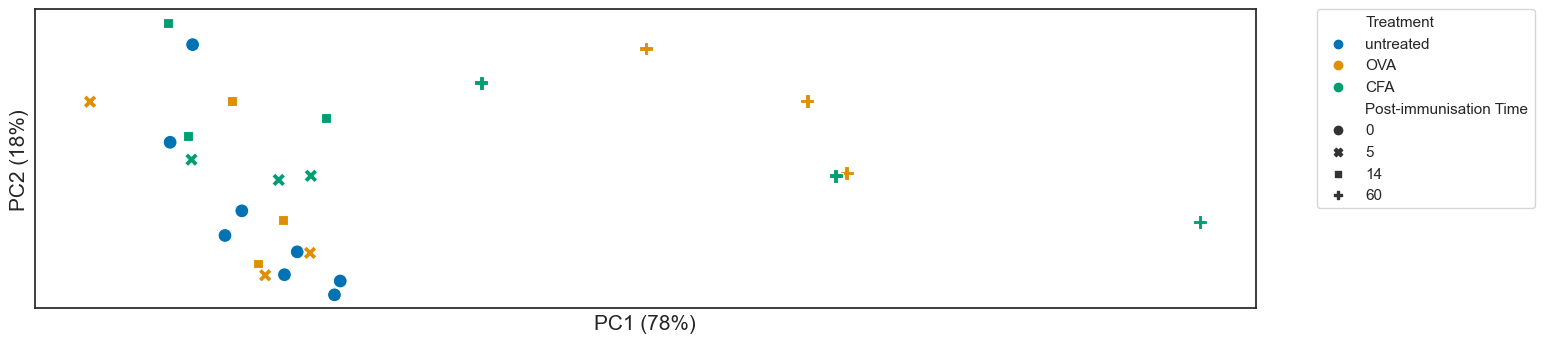

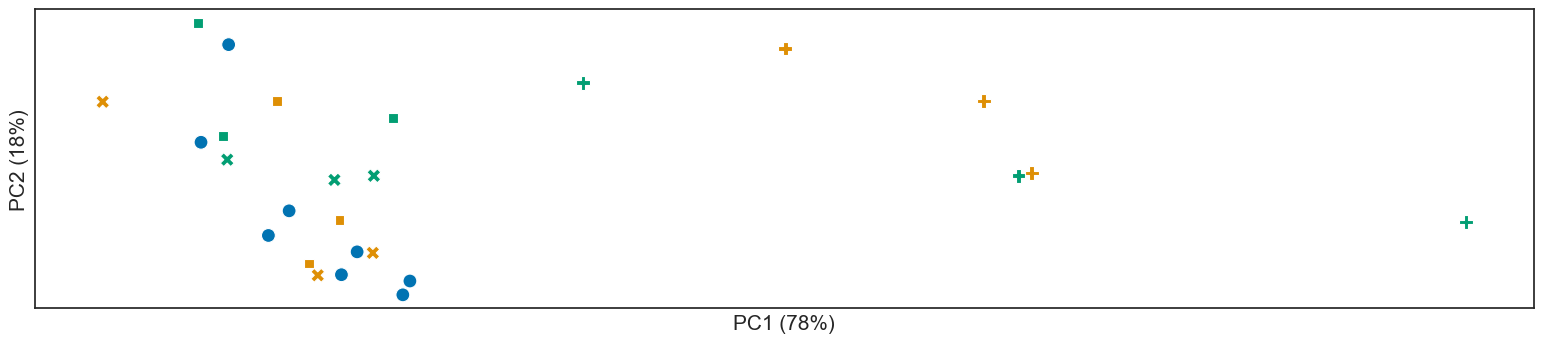

In [134]:
plotPCA(pca_qDZ_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ_w_legend.pdf", True)

plotPCA(pca_qDZ_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ.pdf", False)





### PCA on identity qD

In [135]:
col_without_identity = [colname for colname in list(divP1_all_df) if "L" in colname] 
col_without_identity = [colname for colname in col_without_identity if "identity" not in colname] 

In [136]:
divP1_identity_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                  ] + col_without_identity, axis=1)









divP1_identity_treatment_time



L_identity_q_0 L_identity_q_1 L_identity_q_2 L_identity_q_3 L_identity_q_4  \
0       10.382668       9.923739       8.372279       7.036656       6.412983   
1       10.326825       9.820479       8.396385       7.263158        6.71513   
2        10.31331        9.79213       8.100211       6.797395       6.225713   
3       10.246013       9.575262       7.577281       6.362968       5.830811   
4       10.264618       9.661774       7.634989       6.329691       5.786627   
5        9.606832        7.06856       4.020438       3.251835       2.928516   
6        9.976087       9.062567       7.001029       5.942707       5.461566   
7        9.986311       8.181686        5.40985       4.617796       4.263005   
8       10.375895       9.827401       7.646447       6.153441       5.541584   
9       10.326137       9.824799       8.409804       7.173725       6.543145   
10      10.351852       9.391342       5.400699        4.11813       3.664288   
11      10.381676       9.615025       6.008304       4.585112       4.079247   
12      10.291908       9.514309       6.036021       4.613508       4.105029   
13      10.322198       9.270683       5.413999       4.152416       3.696211   
14      10.208469        8.78081       4.458242       3.389746       3.015706   
15      10.410004       9.965362        8.27124       6.745656       6.055319   
16      10.143881        8.58955       4.215854        3.20557       2.852566   
17      10.144275       8.236502       3.537238       2.677041       2.381074   
18      10.209353       9.156922       5.606193       4.358172       3.898265   
19      10.377265       9.742716       6.919799       5.376013       4.789254   
20       9.933435       6.929036       2.376032        1.78866       1.590088   
21        9.88461       6.877244       2.442972       1.839242       1.635042   
22      10.049577       7.581359       2.833092       2.132474        1.89572   
23       9.651108       5.324217       1.523847       1.145975       1.018719   
24        9.69591       5.713925        1.74229       1.311347       1.165772   
25       9.796236       5.993273       1.797439         1.3515       1.201407   

   L_identity_q_5 L_identity_q_6 L_identity_q_11  Treatment  \
0        6.070457       5.854117        4.903576  untreated   
1        6.402802       6.199004        5.221356  untreated   
2        5.923223       5.737541         4.94766  untreated   
3         5.53916       5.355951        4.558287  untreated   
4        5.498708       5.320486         4.53192  untreated   
5        2.754211       2.646466        2.206366  untreated   
6        5.184441       5.003084        4.187777  untreated   
7        4.055372       3.918524        3.288226  untreated   
8        5.220811       5.023489        4.197042        OVA   
9        6.182602       5.952199        4.970454        OVA   
10       3.435642       3.298263         2.74856        OVA   
11       3.824624       3.671679        3.059738        CFA   
12        3.84884        3.69493        3.079114        CFA   
13       3.465669       3.327097        2.772589        CFA   
14       2.827485       2.714418        2.262019        OVA   
15       5.688548       5.464007        4.554477        OVA   
16       2.674665       2.567733        2.139786        CFA   
17       2.232401       2.143121        1.785936        CFA   
18       3.661105       3.516666        2.931444        CFA   
19       4.490918       4.311394        3.592842        OVA   
20       1.490714       1.431086        1.192571        OVA   
21       1.532858       1.471544        1.226287        CFA   
22       1.777246       1.706157        1.421797        CFA   
23       0.955052        0.91685        0.764042        CFA   
24       1.092916         1.0492        0.874333        OVA   
25       1.126322       1.081269        0.901057        OVA   

    Post-immunisation Time  
0                        0  
1                        0  
2                        0

In [137]:
observables = [col for col in list(divP1_identity_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x_qDZ_identity1 = divP1_identity_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ_identity1 = divP1_identity_treatment_time.loc[:,'Treatment'].values

In [138]:
x_qDZ_identity1.shape

(26, 8)

In [139]:
x_qDZ_identity1.mean(), x_qDZ_identity1.std()

(5.352664129669874, 2.9604039586641617)

In [140]:
x_qDZ_identity1_scaled = StandardScaler().fit_transform(x_qDZ_identity1)

In [141]:
x_qDZ_identity1_scaled.mean(), x_qDZ_identity1_scaled.std()

(1.8895141861408914e-16, 1.0)

In [142]:
pca_qDZ_identity1_scaled = decomposition.PCA(n_components=8)
principalComponents_qDZ_identity1_scaled = pca_qDZ_identity1_scaled.fit_transform(x_qDZ_identity1_scaled)

principalDf_qDZ_identity1_scaled = pd.DataFrame(data = principalComponents_qDZ_identity1_scaled)
principalDf_qDZ_identity1_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_identity1_scaled)]
finalDf_qDZ_identity1_scaled = pd.concat([principalDf_qDZ_identity1_scaled, divP1_identity_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50001/2086500981.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


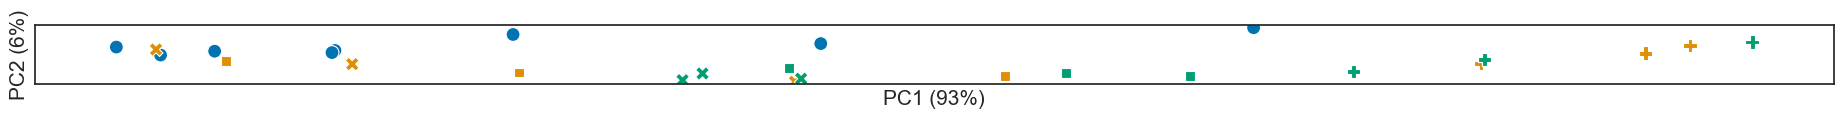

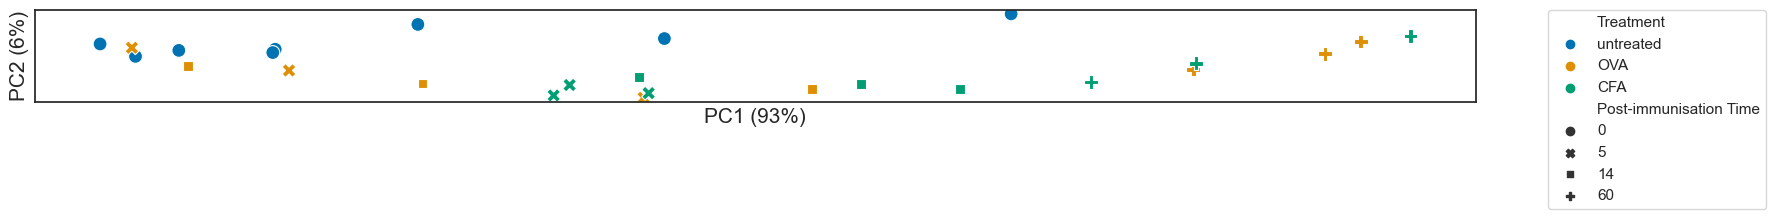

In [143]:
plotPCA(pca_qDZ_identity1_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity.pdf", False)

plotPCA(pca_qDZ_identity1_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity_w_legend.pdf", True)






### Exp(Shannon index) separation 

In [144]:
divP1_identity_q1_treatment_time = divP1_all_df[["L_identity_q_1", "Post-immunisation Time", "Treatment"]]

divP1_identity_q1_treatment_time



L_identity_q_1  Post-immunisation Time  Treatment
0        9.923739                       0  untreated
1        9.820479                       0  untreated
2         9.79213                       0  untreated
3        9.575262                       0  untreated
4        9.661774                       0  untreated
5         7.06856                       0  untreated
6        9.062567                       0  untreated
7        8.181686                       0  untreated
8        9.827401                       5        OVA
9        9.824799                       5        OVA
10       9.391342                       5        OVA
11       9.615025                       5        CFA
12       9.514309                       5        CFA
13       9.270683                       5        CFA
14        8.78081                      14        OVA
15       9.965362                      14        OVA
16        8.58955                      14        CFA
17       8.236502                      14        CFA
18       9.156922                      14        CFA
19       9.742716                      14        OVA
20       6.929036                      60        OVA
21       6.877244                      60        CFA
22       7.581359                      60        CFA
23       5.324217                      60        CFA
24       5.713925                      60        OVA
25       5.993273                      60        OVA

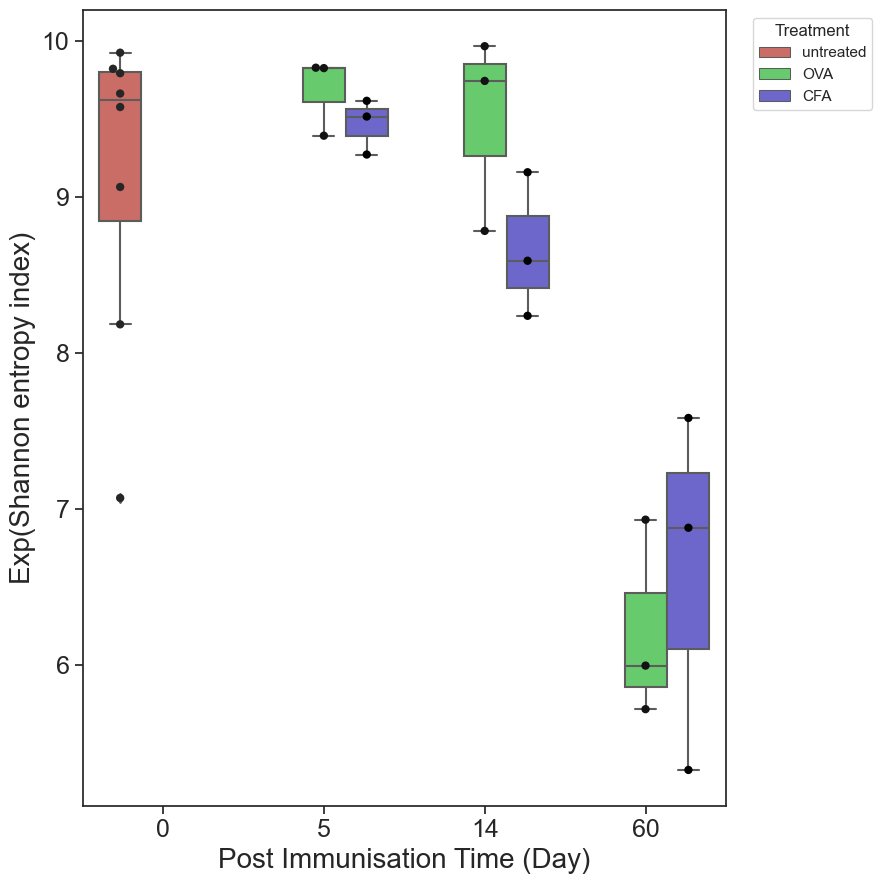

In [145]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q1_treatment_time["Treatment"]))))
p = sns.boxplot(x="Post-immunisation Time", y="L_identity_q_1", hue="Treatment",
                 data=divP1_identity_q1_treatment_time, palette=cmap)
p = sns.swarmplot(x="Post-immunisation Time", y="L_identity_q_1", hue="Treatment",data=divP1_identity_q1_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)

# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q1_treatment_time["Treatment"])))], labels[0:len(list(set(divP1_identity_q1_treatment_time["Treatment"])))], 
                   title = "Treatment", loc=2, bbox_to_anchor=(1.03, 1))


plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Post Immunisation Time (Day)", fontsize = 20)
plt.ylabel("Exp(Shannon entropy index)", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Exp_Shannon_entropy_barplot.pdf")

### Gini analogue separation

In [146]:
divP1_identity_q2_treatment_time = divP1_all_df[["L_identity_q_2", "Post-immunisation Time", "Treatment"]]

divP1_identity_q2_treatment_time



L_identity_q_2  Post-immunisation Time  Treatment
0        8.372279                       0  untreated
1        8.396385                       0  untreated
2        8.100211                       0  untreated
3        7.577281                       0  untreated
4        7.634989                       0  untreated
5        4.020438                       0  untreated
6        7.001029                       0  untreated
7         5.40985                       0  untreated
8        7.646447                       5        OVA
9        8.409804                       5        OVA
10       5.400699                       5        OVA
11       6.008304                       5        CFA
12       6.036021                       5        CFA
13       5.413999                       5        CFA
14       4.458242                      14        OVA
15        8.27124                      14        OVA
16       4.215854                      14        CFA
17       3.537238                      14        CFA
18       5.606193                      14        CFA
19       6.919799                      14        OVA
20       2.376032                      60        OVA
21       2.442972                      60        CFA
22       2.833092                      60        CFA
23       1.523847                      60        CFA
24        1.74229                      60        OVA
25       1.797439                      60        OVA

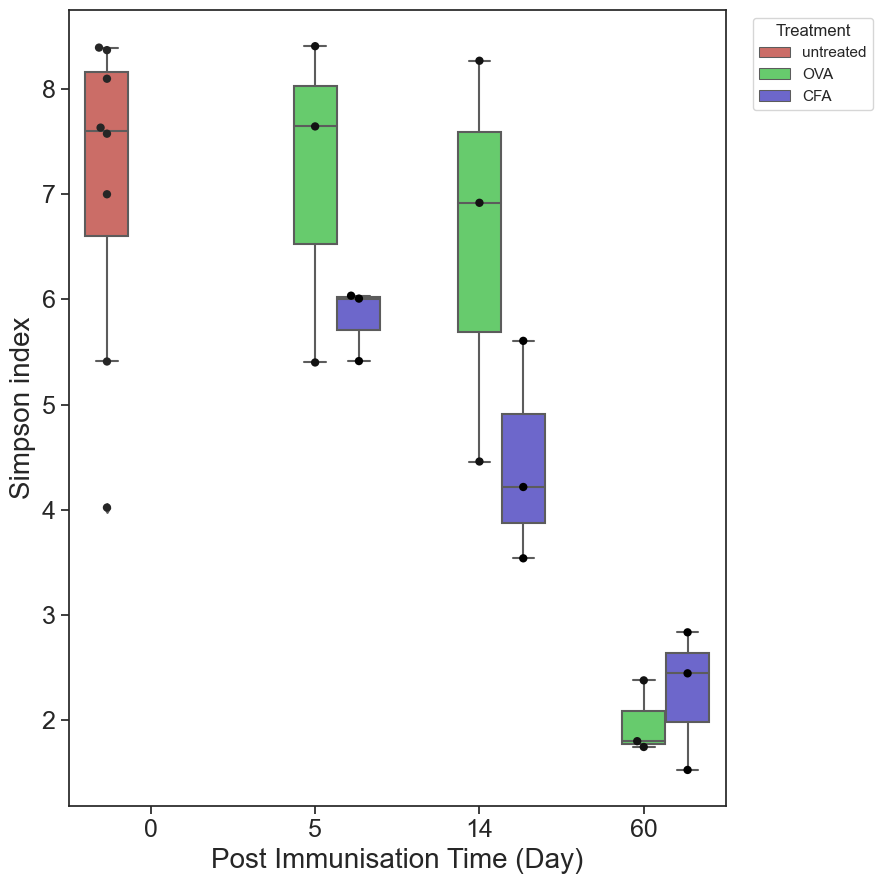

In [147]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q2_treatment_time["Treatment"]))))
p = sns.boxplot(x="Post-immunisation Time", y="L_identity_q_2", hue="Treatment",
                 data=divP1_identity_q2_treatment_time, palette=cmap)
p = sns.swarmplot(x="Post-immunisation Time", y="L_identity_q_2", hue="Treatment",data=divP1_identity_q2_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)
# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q2_treatment_time["Treatment"])))], labels[0:len(list(set(divP1_identity_q2_treatment_time["Treatment"])))], 
                   title = "Treatment", loc=2, bbox_to_anchor=(1.03, 1))


#p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Post Immunisation Time (Day)", fontsize = 20)
plt.ylabel("Simpson index", fontsize = 20)

plt.tight_layout()
plt.savefig(wdir_path + "Gini_Simpson_index_barplot.pdf")

### Shannon vs Gini-Simpson 

In [148]:
divP_Shannon_Gini = divP1_identity_q2_treatment_time.copy()
divP_Shannon_Gini["L_identity_q_1"] = divP1_identity_q1_treatment_time["L_identity_q_1"]
divP_Shannon_Gini

L_identity_q_2  Post-immunisation Time  Treatment L_identity_q_1
0        8.372279                       0  untreated       9.923739
1        8.396385                       0  untreated       9.820479
2        8.100211                       0  untreated        9.79213
3        7.577281                       0  untreated       9.575262
4        7.634989                       0  untreated       9.661774
5        4.020438                       0  untreated        7.06856
6        7.001029                       0  untreated       9.062567
7         5.40985                       0  untreated       8.181686
8        7.646447                       5        OVA       9.827401
9        8.409804                       5        OVA       9.824799
10       5.400699                       5        OVA       9.391342
11       6.008304                       5        CFA       9.615025
12       6.036021                       5        CFA       9.514309
13       5.413999                       5        CFA       9.270683
14       4.458242                      14        OVA        8.78081
15        8.27124                      14        OVA       9.965362
16       4.215854                      14        CFA        8.58955
17       3.537238                      14        CFA       8.236502
18       5.606193                      14        CFA       9.156922
19       6.919799                      14        OVA       9.742716
20       2.376032                      60        OVA       6.929036
21       2.442972                      60        CFA       6.877244
22       2.833092                      60        CFA       7.581359
23       1.523847                      60        CFA       5.324217
24        1.74229                      60        OVA       5.713925
25       1.797439                      60        OVA       5.993273

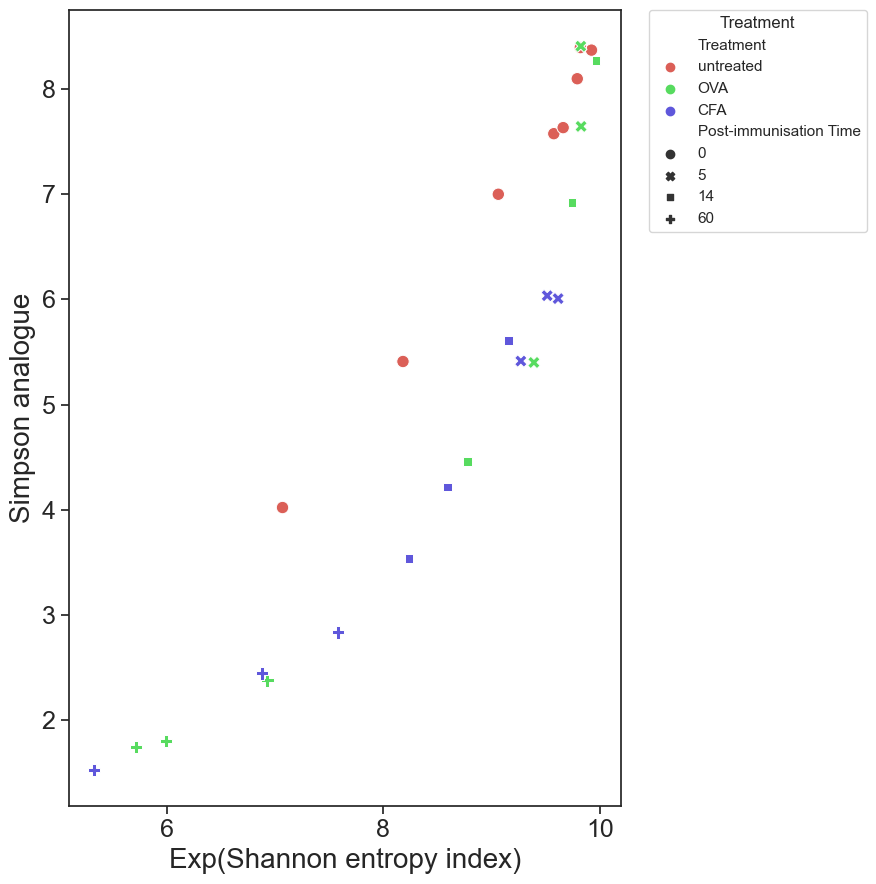

In [149]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP_Shannon_Gini["Treatment"]))))
p = sns.scatterplot(x="L_identity_q_1", y="L_identity_q_2", 
                     data=divP_Shannon_Gini,
                     hue="Treatment", palette=cmap,  
                     style = "Post-immunisation Time", 
                    s = 80
                   )




p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Exp(Shannon entropy index)", fontsize = 20)
plt.ylabel("Simpson analogue", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Shannon_vs_Gini_Simpson_index_scatter_plot.pdf")




# Hierarchical clustering 

## Cluster divP features 

In [150]:
divP_features_HC = divP_features_treatment_time.copy()

divP_features_HC = divP_features_HC.set_index(["Treatment", "Post-immunisation Time"])

divP_features_HC

identity_64.0_area  identity_32.0_area  \
Treatment Post-immunisation Time                                           
untreated 0                                 0.424284            2.389571   
          0                                 0.448165            2.512506   
          0                                 0.441307            2.356802   
          0                                 0.395162            2.061805   
          0                                 0.369116            1.949766   
          0                                 0.183637            1.081568   
          0                                 0.305508            1.659503   
          0                                 0.173277            1.187882   
OVA       5                                 0.356008            2.128832   
          5                                 0.333495            2.212615   
          5                                 0.228693            1.553180   
CFA       5                                 0.244184            1.657182   
          5                                 0.301026            1.791951   
          5                                 0.215459            1.547693   
OVA       14                                0.223311            1.452793   
          14                                0.336161            2.138313   
CFA       14                                0.232145            1.469256   
          14                                0.227150            1.431618   
          14                                0.255264            1.596266   
OVA       14                                0.293848            1.851480   
          60                                0.183495            1.211616   
CFA       60                                0.147596            1.067760   
          60                                0.217919            1.343637   
          60                                0.136202            0.938153   
OVA       60                                0.135938            0.949589   
          60                                0.173087            1.100734   

                                  identity_16.0_area  identity_8.0_area  \
Treatment Post-immunisation Time                                          
untreated 0                                 9.366182          23.487257   
          0                                10.863940          25.149938   
          0                                 9.058862          22.954419   
          0                                 7.342355          19.904310   
          0                                 6.892452          19.221763   
          0                                 3.321378           6.373926   
          0                                 5.796937          16.657229   
          0                                 3.893540           9.152904   
OVA       5                                 7.257564          19.032172   
          5                                 9.383590          23.634212   
          5                                 4.725906           9.486413   
CFA       5                                 5.140896          10.961197   
          5                                 5.387567          11.414782   
          5                                 4.753513           9.897322   
OVA       14                                4.324143           8.236185   
          14                                8.003410          21.301272   
CFA       14                                4.291161           7.997736   
          14                                4.151434           7.407260   
          14                                4.825708           9.962941   
OVA       14                                5.963391          14.481576   
          60                                3.633262           6.571456   
CFA       60                                3.362898           6.335083   
          60                                3.872622           6.880555   
          60                  

<Figure size 600x800 with 0 Axes>

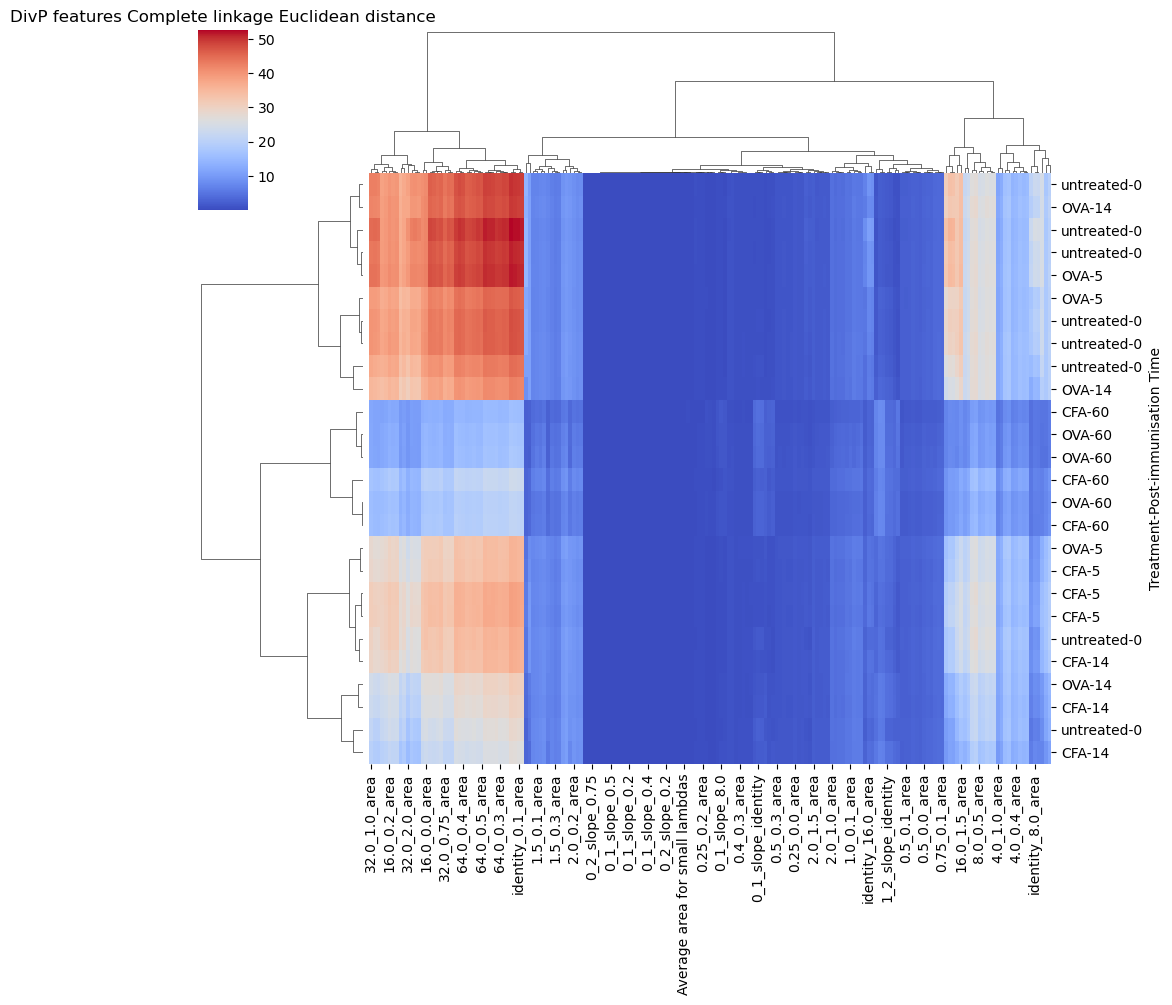

In [151]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_features_HC,
               method='complete',
                metric='euclidean',
              cmap="coolwarm")

if not os.path.isdir(wdir_path+"heatmaps/"):
        os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
    
plt.title("DivP features Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_divP_features.png", bbox_inches='tight')


## Cluster true diversity

In [152]:
divP_qDZ_HC = divP1_all_df.copy()

divP_qDZ_HC = divP_qDZ_HC.set_index(["Treatment", "Post-immunisation Time"])

divP_qDZ_HC = divP_qDZ_HC.drop(["unique_CDR3s", "library", "sample_name", "sample_type"], axis = 1)
divP_qDZ_HC

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3  \
Treatment Post-immunisation Time                                           
untreated 0                        0.08906  0.088812   0.08857  0.088334   
          0                       0.086739  0.086491  0.086249  0.086014   
          0                       0.087098  0.086837  0.086583  0.086335   
          0                       0.089333  0.089076  0.088825  0.088581   
          0                       0.092167   0.09191   0.09166  0.091415   
          0                       0.099724  0.099476  0.099234  0.098998   
          0                       0.092774  0.092495  0.092222  0.091956   
          0                       0.095983  0.095764  0.095549  0.095339   
OVA       5                       0.088565  0.088311  0.088063  0.087821   
          5                       0.089513  0.089269  0.089029  0.088796   
          5                        0.10169  0.101352  0.101022  0.100702   
CFA       5                       0.095417  0.095144  0.094877  0.094615   
          5                       0.091954  0.091681  0.091413  0.091152   
          5                       0.089861  0.089634  0.089413  0.089197   
OVA       14                      0.095589  0.095372   0.09516  0.094952   
          14                      0.089804  0.089561  0.089324  0.089092   
CFA       14                      0.091346   0.09114  0.090939  0.090742   
          14                      0.102384  0.102137  0.101895  0.101656   
          14                      0.096726   0.09645  0.096178  0.095913   
OVA       14                      0.089964  0.089724   0.08949   0.08926   
          60                      0.074381  0.074043  0.073713  0.073391   
CFA       60                      0.074253  0.073951  0.073655  0.073365   
          60                      0.088165  0.087979  0.087798  0.087622   
          60                      0.062679  0.062269   0.06187  0.061481   
OVA       60                      0.080497  0.080174  0.079858   0.07955   
          60                      0.087938  0.087652  0.087373  0.087101   

                                 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6 L_0.1_q_11  \
Treatment Post-immunisation Time                                            
untreated 0                       0.088104  0.087879  0.087659    0.06334   
          0                       0.085785  0.085562  0.085344   0.061627   
          0                       0.086094  0.085859   0.08563   0.061471   
          0                       0.088342  0.088109  0.087882   0.063424   
          0                       0.091176  0.090942  0.090713   0.065311   
          0                       0.098767  0.098542  0.098322   0.072395   
          0                       0.091696  0.091442  0.091193   0.065779   
          0                       0.095133  0.094931  0.094733   0.068627   
OVA       5                       0.087585  0.087354  0.087129   0.062705   
          5                       0.088567  0.088344  0.088125   0.063453   
          5                       0.100389  0.100084  0.099786   0.071779   
CFA       5                        0.09436   0.09411  0.093865   0.067587   
          5                       0.090896  0.090645    0.0904   0.064951   
          5                       0.088986  0.088779  0.088577   0.063999   
OVA       14                      0.094747  0.094545  0.094348   0.068645   
          14                      0.088865  0.088643  0.088425   0.063655   
CFA       14                      0.090549   0.09036  0.090174   0.065608   
          14                      0.101422  0.101191  0.100964   0.073844   
          14                      0.095652  0.095397  0.095147   0.068679   
OVA       14                      0.089036  0.088816  0.088602   0.063789   
          60                      0.073078  0.072771  0.072473   0.050605   
CFA       60                      0.073081  0.072803   0.07253   0.049913   
          60                       0.08745  0.087284  0.

In [153]:
divP_qDZ_HC.isnull().values.any()

False

In [154]:
divP_qDZ_HC = divP_qDZ_HC.apply(pd.to_numeric) 

In [155]:
divP_qDZ_HC.dtypes

L_0.1_q_0          float64
L_0.1_q_1          float64
L_0.1_q_2          float64
L_0.1_q_3          float64
L_0.1_q_4          float64
                    ...   
L_identity_q_3     float64
L_identity_q_4     float64
L_identity_q_5     float64
L_identity_q_6     float64
L_identity_q_11    float64
Length: 128, dtype: object

<Figure size 600x800 with 0 Axes>

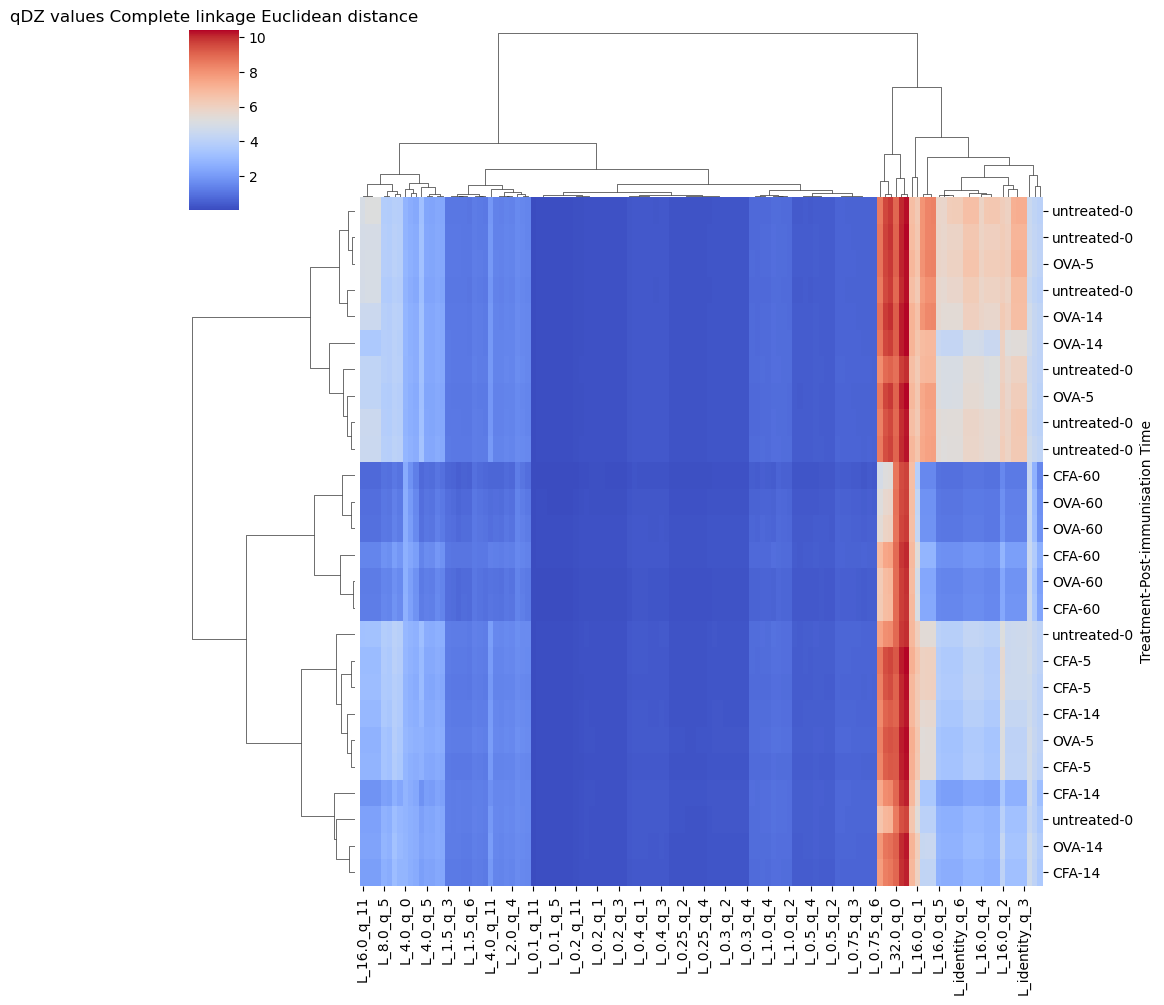

In [156]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_qDZ_HC,
               method='complete',
                metric='euclidean',
                cmap="coolwarm"
                   )
if not os.path.isdir(wdir_path+"heatmaps/"):
        os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
    

plt.title("qDZ values Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_qDZ.png", bbox_inches='tight')
